In [171]:
import os
import copy
import torch
import json
import time
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
import random
from scipy.stats import wilcoxon
from gpolnel.utils.inductive_programming import function_map, prm_reconstruct_tree, _get_tree_depth

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
#from mlxtend.plotting import plot_decision_regions
from gpolnel.utils.tree import Tree
from gpolnel.problems.inductive_programming import SML
#from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map, _get_tree_depth
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm, GSGP
from gpolnel.operators.initializers import grow, prm_grow, ERC, Terminal
from gpolnel.problems.problem import Problem
from gpolnel.operators.selectors import prm_tournament
#from gpolnel.operators.variators import prm_efficient_gs_mtn
from gpolnel.problems.inductive_programming import SMLGS, SML
from gpolnel.operators.variators import prm_gs_xo, prm_gs_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn
import codecs
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn
#import neat

#from gpolnel.operators.variators import prm_efficient_gs_mtn
#from gpolnel.operators.selectors import prm_tournament

In [144]:
data = pd.read_csv("data_project_nel.csv")
y_fat = pd.read_csv("y_fat.csv")
y_lactose = pd.read_csv("y_lactose.csv")
y_protein = pd.read_csv("y_protein.csv")

In [145]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2


In [146]:
data.shape

(324, 14)

In [147]:
y_fat.head()

,fat_percent
0,3.787156
1,3.645519
2,3.458251
3,3.407140
4,4.902554


In [148]:
y_fat.shape

(324, 1)

In [149]:
y_lactose.head()

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402


In [150]:
y_lactose.shape

(324, 1)

In [151]:
y_protein.head()

,protein_percent
0,3.511685
1,3.470806
2,3.370124
3,3.221164
4,3.395152


In [152]:
y_protein.shape

(324, 1)

In [153]:
data = pd.concat([data, y_lactose, y_fat, y_protein], axis=1)

In [154]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0,4.953503,3.787156,3.511685
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0,4.983128,3.645519,3.470806
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8,4.889104,3.458251,3.370124
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2,4.868969,3.407140,3.221164
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2,4.845402,4.902554,3.395152


In [155]:
data.isnull().sum()

lactation                     0
delivery_age_years            0
dim                           0
dry_days                    147
forage_kg_day                 0
rumination_min_day            0
milk_kg_day                   0
milk_kg_min_robot             0
milkings_day                  0
errors_by_100_milkings        0
high_cdt_by_100_milkings      0
watery_by_100_milkings        0
refusals_by_milking           0
colostrum_separated_kg        0
lactose_percent               0
fat_percent                   0
protein_percent               0
dtype: int64

In [156]:
data.drop('dry_days', axis=1, inplace=True)

C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

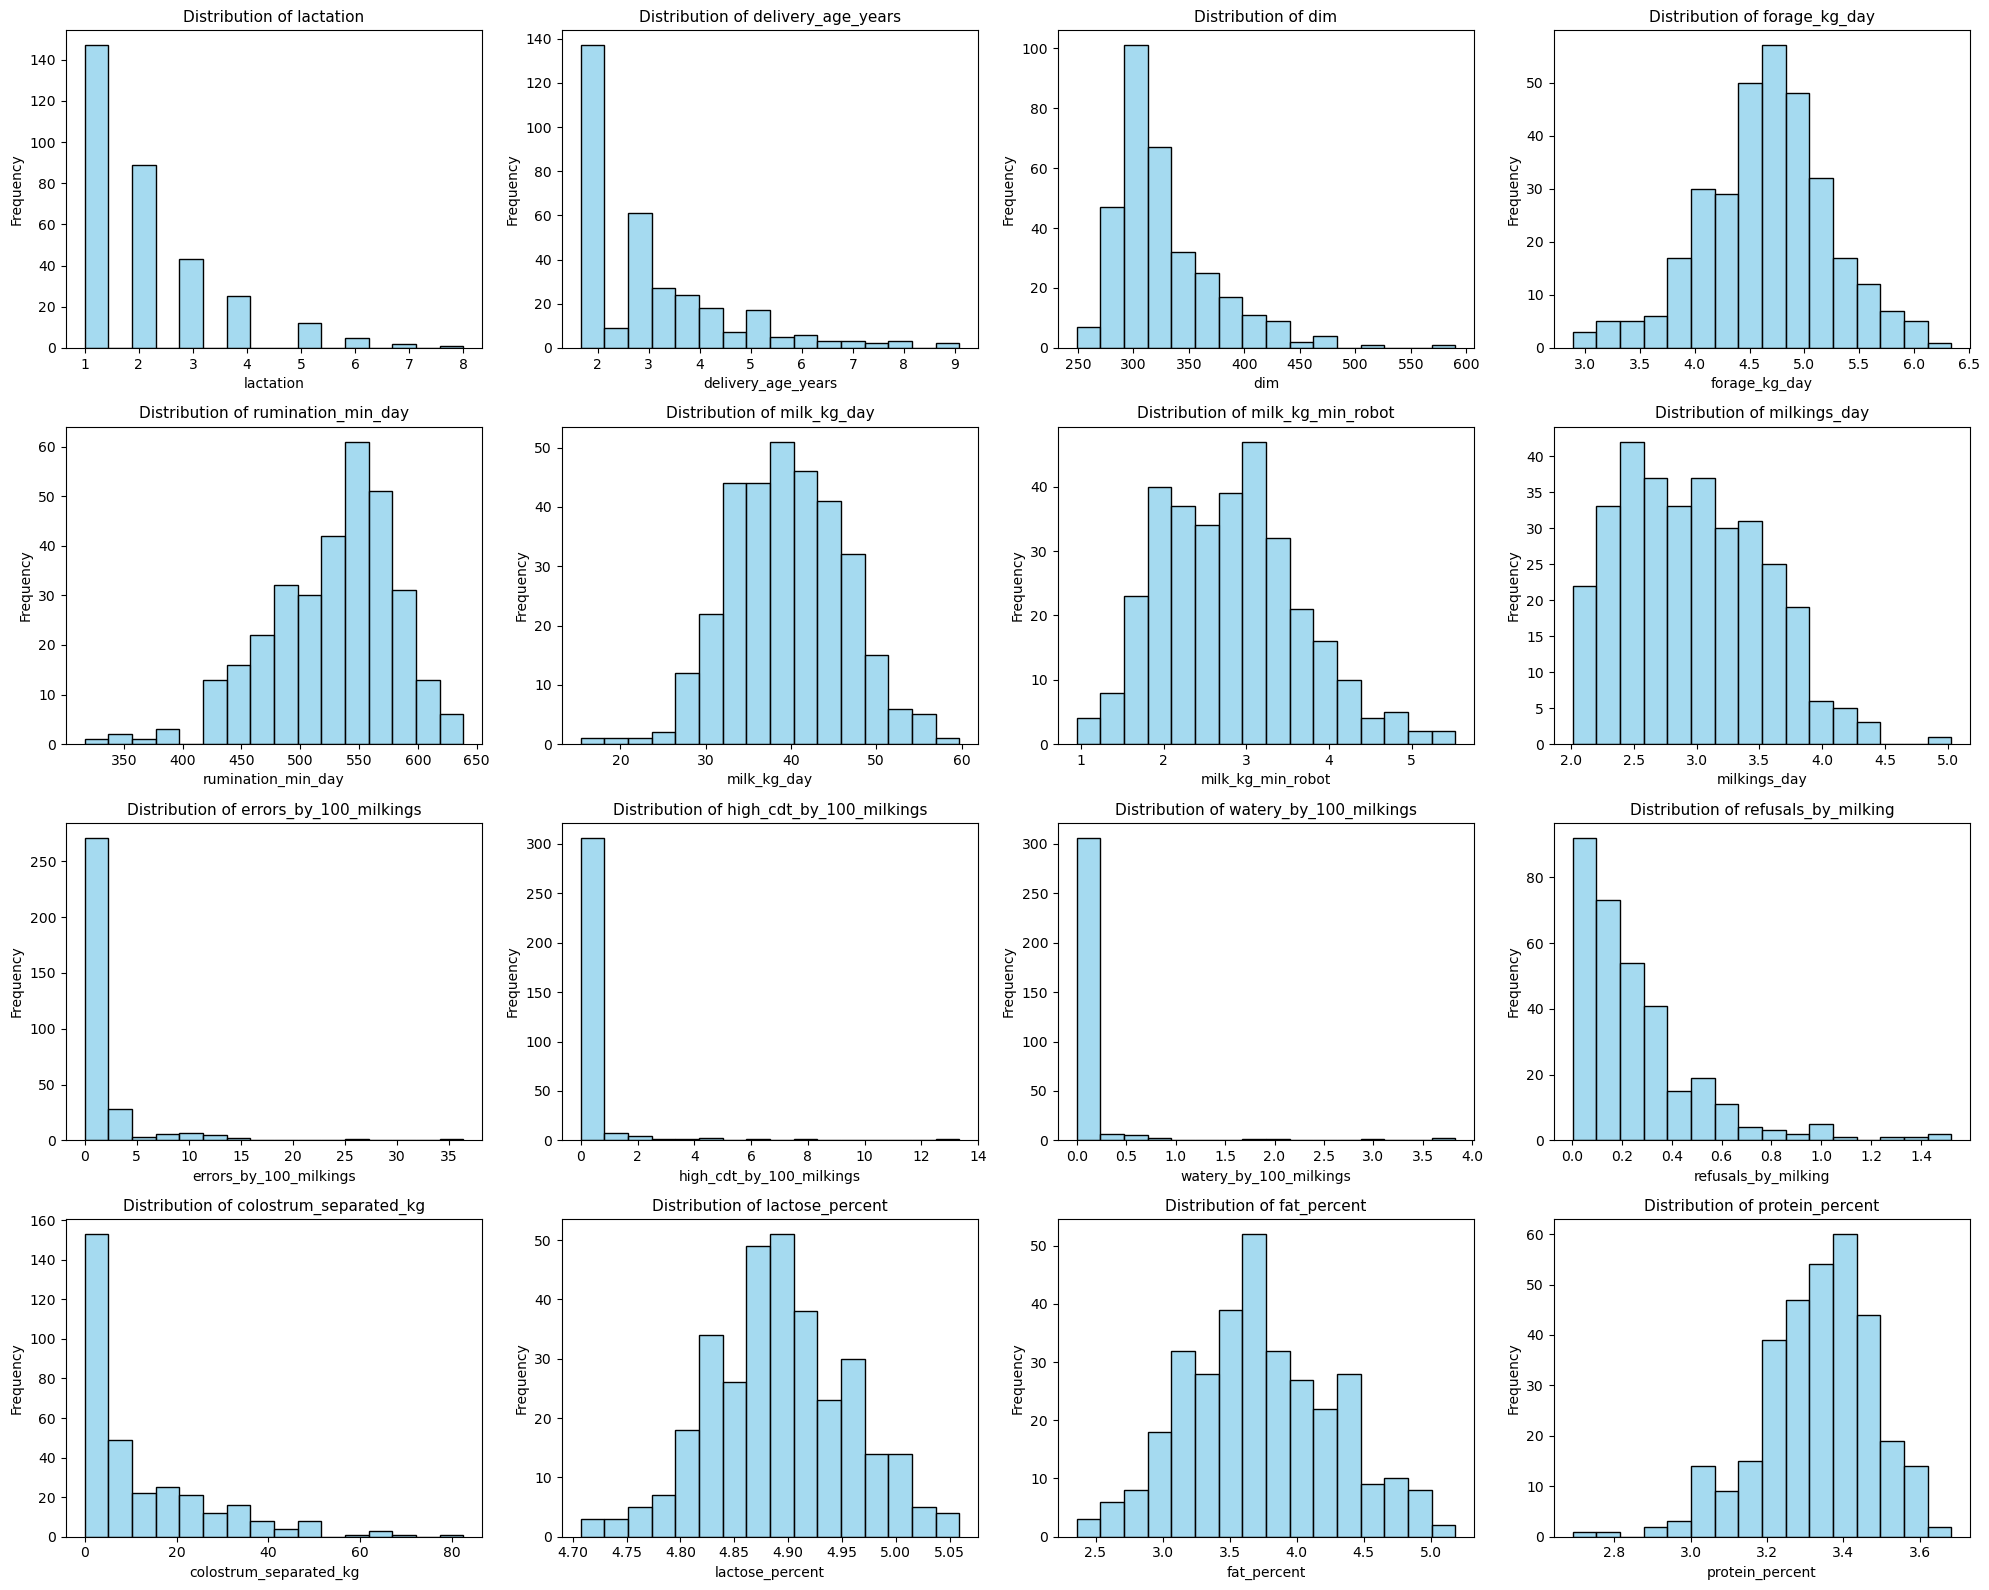

In [157]:
num_columns = len(data.columns)

# Number of rows and columns for subplots
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [158]:
#lactation is categorical so we did one hot encoding here
data = pd.get_dummies(data, columns=['lactation'])
data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)

In [159]:
data.head()

,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,...,fat_percent,protein_percent,lactation_1,lactation_2,lactation_3,lactation_4,lactation_5,lactation_6,lactation_7,lactation_8
0,7.750000,414,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,...,3.787156,3.511685,False,0,0,0,0,0,1,0
1,9.083333,357,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,...,3.645519,3.470806,False,0,0,0,0,0,0,1
2,7.666667,315,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,...,3.458251,3.370124,False,0,0,0,0,1,0,0
3,8.666667,362,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,...,3.407140,3.221164,False,0,0,0,0,0,1,0
4,6.500000,427,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,...,4.902554,3.395152,False,0,0,0,1,0,0,0


In [160]:
spearman_corr_matrix = data.corr(method='spearman')

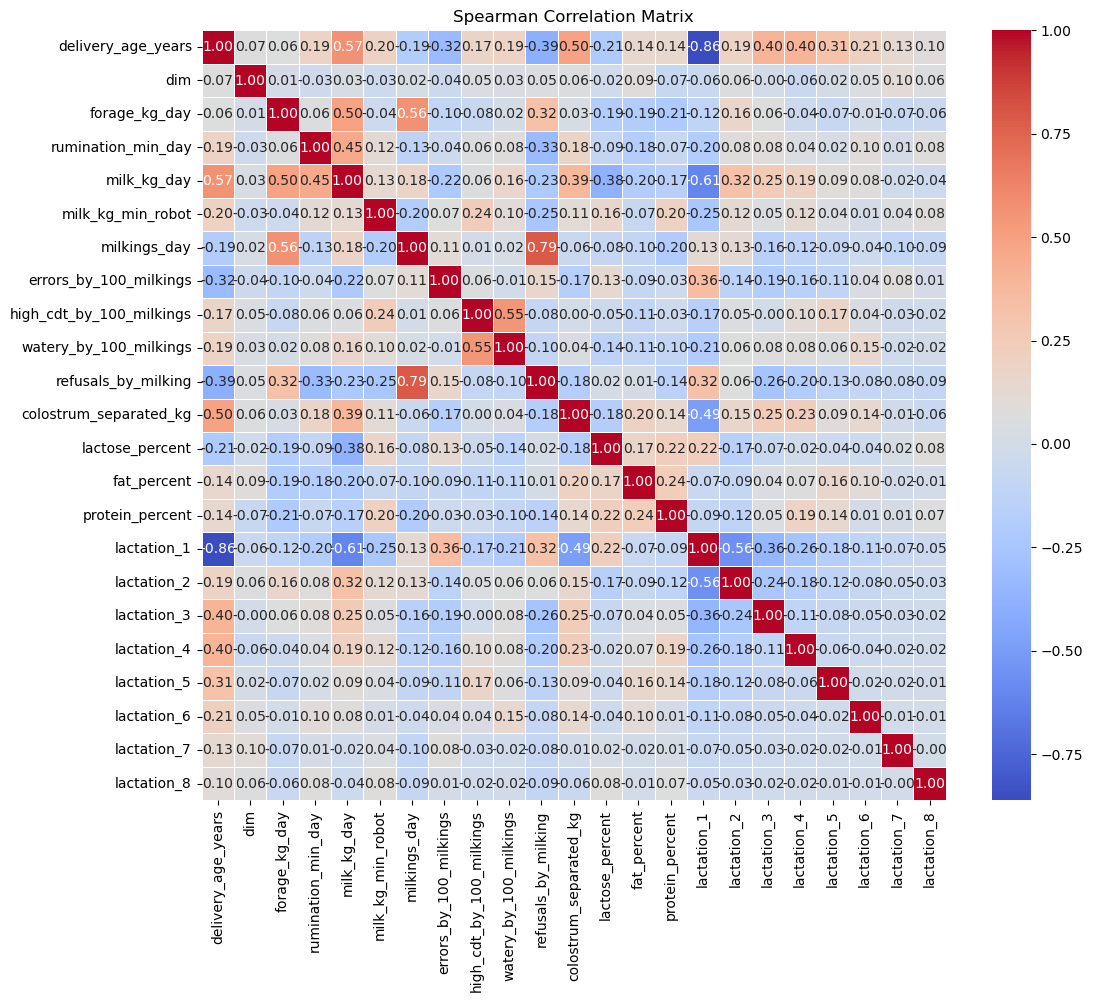

In [161]:
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(spearman_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Add title
plt.title('Spearman Correlation Matrix')
plt.show()

C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dggua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

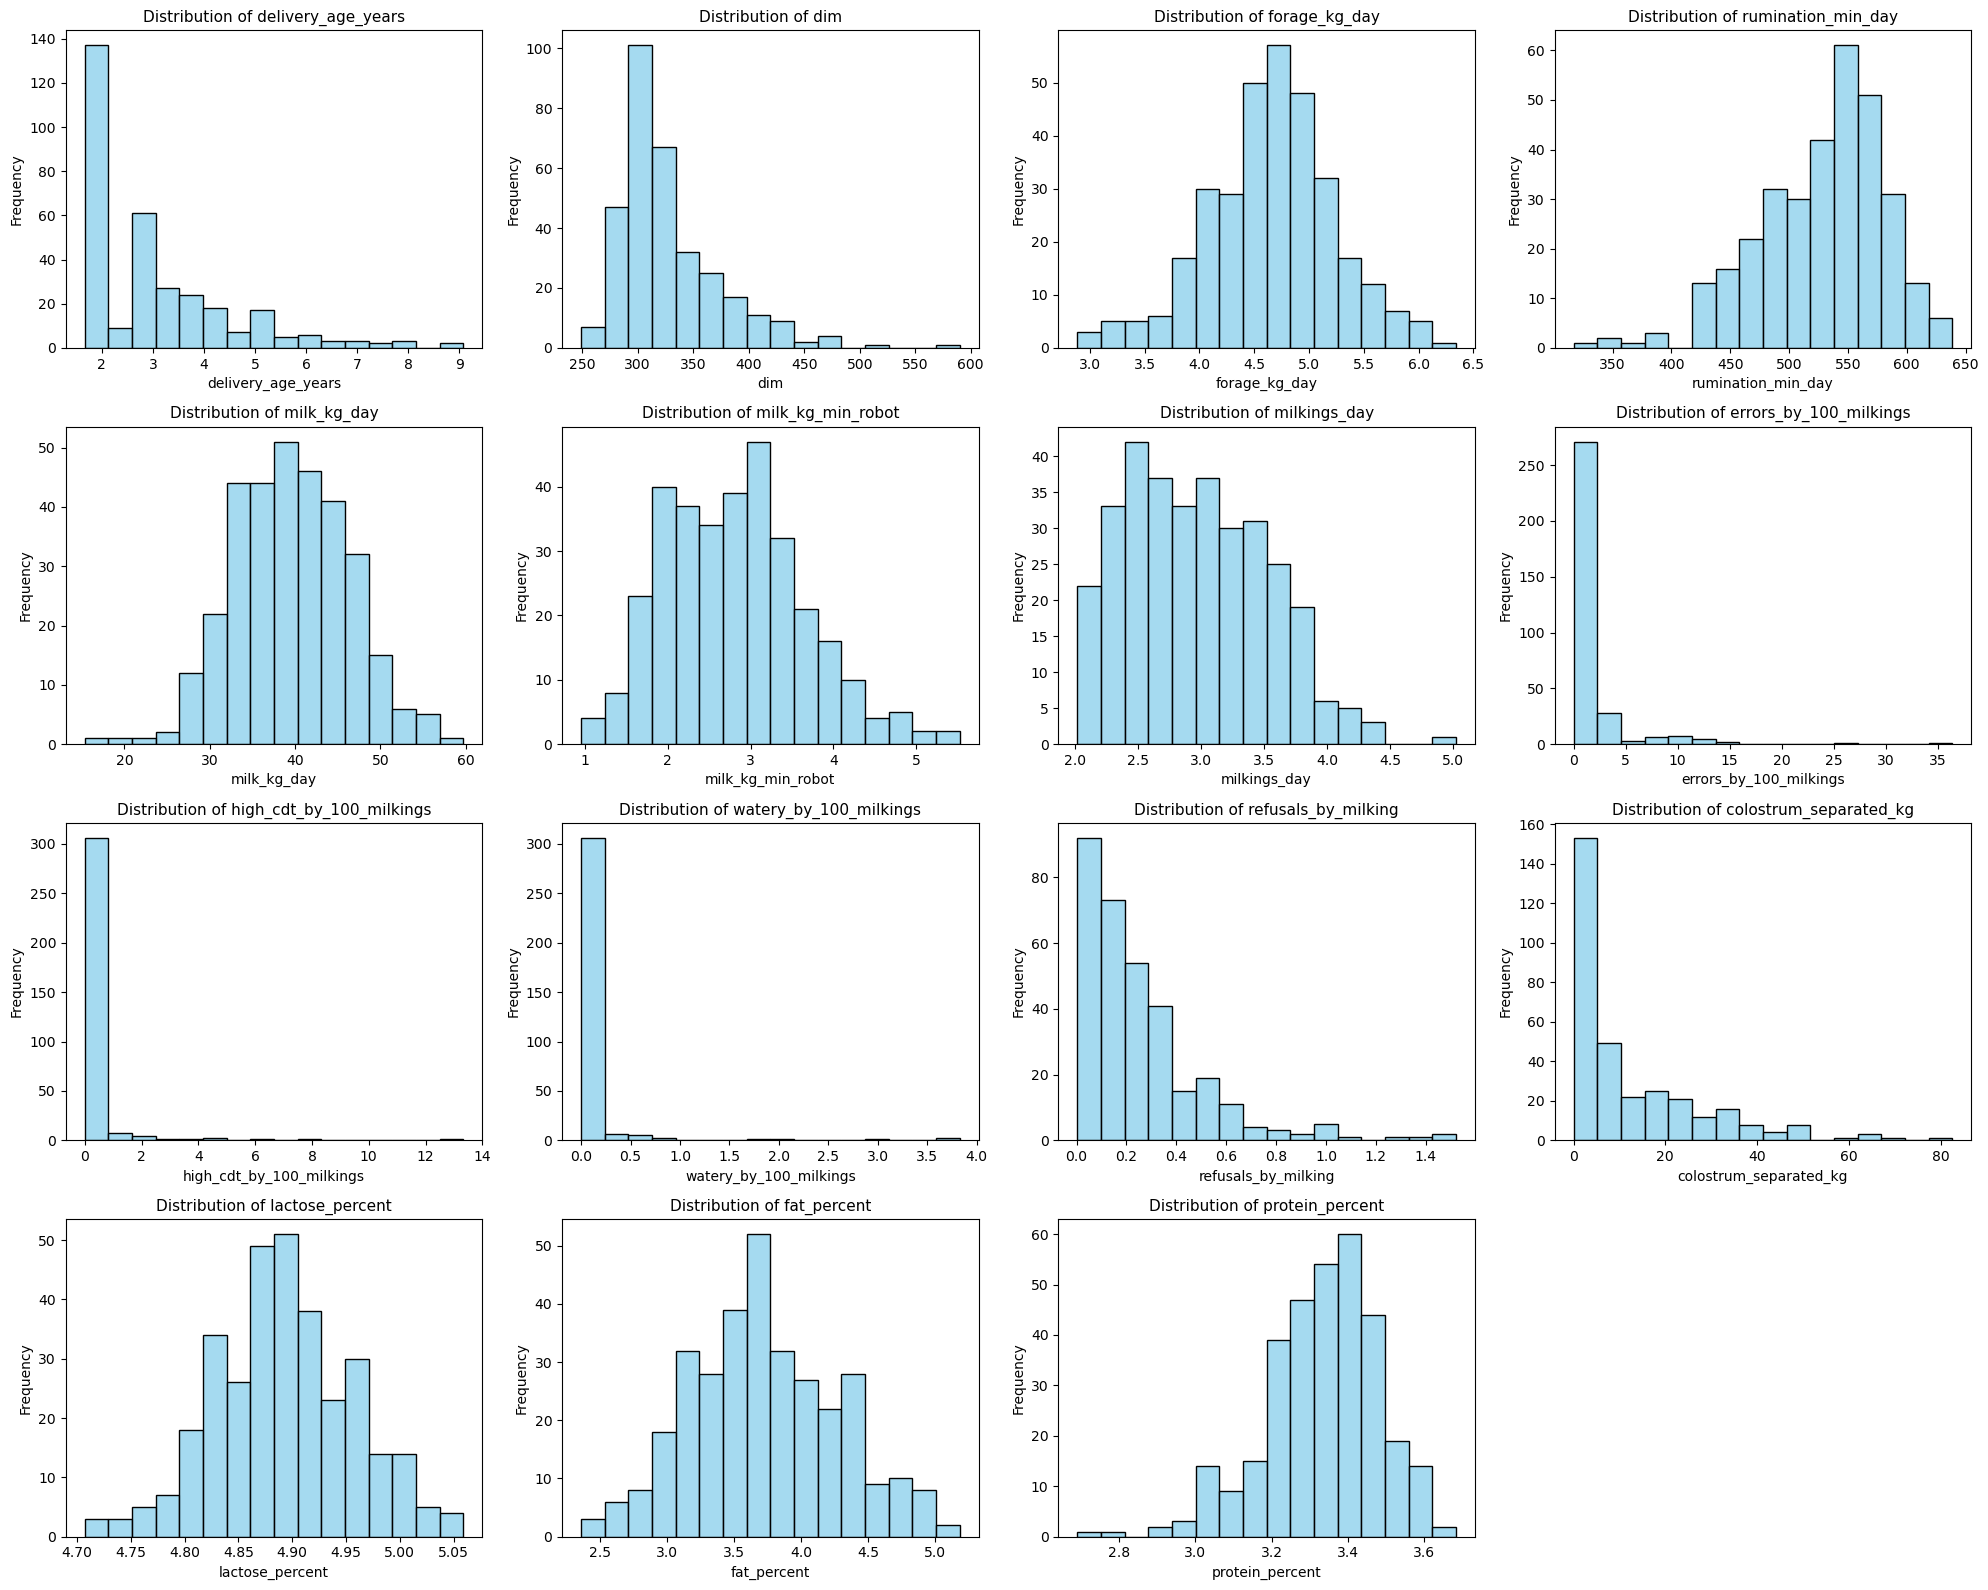

In [162]:
columns_to_plot = [col for col in data.columns if not col.startswith('lactation_')]

num_columns = len(columns_to_plot)

n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [163]:
X = data.drop(columns=["fat_percent", "lactose_percent", "protein_percent"])
y_fat = data["fat_percent"]
y_lactose = data["lactose_percent"]
y_protein = data["protein_percent"]

In [164]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scaler = StandardScaler()

X_train_kf, X_val_kf = [], []
y_fat_train_kf, y_fat_val_kf = [], []
y_lactose_train_kf, y_lactose_val_kf = [], []
y_protein_train_kf, y_protein_val_kf = [], []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fat_train_fold, y_fat_val_fold = y_fat.iloc[train_index], y_fat.iloc[val_index]
    y_lactose_train_fold, y_lactose_val_fold = y_lactose.iloc[train_index], y_lactose.iloc[val_index]
    y_protein_train_fold, y_protein_val_fold = y_protein.iloc[train_index], y_protein.iloc[val_index]

    # Scaler
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Convert to PyTorch tensors
    X_train_fold_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32)
    X_val_fold_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32)
    y_fat_train_fold_tensor = torch.tensor(y_fat_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_fat_val_fold_tensor = torch.tensor(y_fat_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_lactose_train_fold_tensor = torch.tensor(y_lactose_train_fold.to_numpy(), dtype=torch.float32)
    y_lactose_val_fold_tensor = torch.tensor(y_lactose_val_fold.to_numpy(), dtype=torch.float32)

    y_protein_train_fold_tensor = torch.tensor(y_protein_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_protein_val_fold_tensor = torch.tensor(y_protein_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)

    # Append to lists
    X_train_kf.append(X_train_fold_tensor)
    X_val_kf.append(X_val_fold_tensor)
    y_fat_train_kf.append(y_fat_train_fold_tensor)
    y_fat_val_kf.append(y_fat_val_fold_tensor)

    y_lactose_train_kf.append(y_lactose_train_fold_tensor)
    y_lactose_val_kf.append(y_lactose_val_fold_tensor)
    y_protein_train_kf.append(y_protein_train_fold_tensor)
    y_protein_val_kf.append(y_protein_val_fold_tensor)
   

# NEURAL NETWORK

In [23]:
def dataloaders(X_train_kf, X_val_kf, y_train_kf, y_val_kf, batch_sizes):
    train_data = []
    val_data = []

    for i in range(len(X_train_kf)):
        train_ds = TensorDataset(X_train_kf[i], y_train_kf[i])
        val_ds = TensorDataset(X_val_kf[i], y_val_kf[i])

        batch_size_GD = batch_sizes['GD']
        batch_size_SGD = batch_sizes['SGD']
        batch_size_MiniSGD = batch_sizes['MiniSGD']
        batch_size_ASGD = batch_sizes['ASGD']
        batch_size_RMSprop = batch_sizes['RMSprop']

        train_dl_GD = DataLoader(train_ds, batch_size_GD, shuffle=True)
        val_dl_GD = DataLoader(val_ds, batch_size_GD, shuffle=True)
        train_dl_SGD = DataLoader(train_ds, batch_size_SGD, shuffle=True)
        val_dl_SGD = DataLoader(val_ds, batch_size_SGD, shuffle=True)
        train_dl_MiniSGD = DataLoader(train_ds, batch_size_MiniSGD, shuffle=True)
        val_dl_MiniSGD = DataLoader(val_ds, batch_size_MiniSGD, shuffle=True)
        train_dl_ASGD = DataLoader(train_ds, batch_size_ASGD, shuffle=True)
        val_dl_ASGD = DataLoader(val_ds, batch_size_ASGD, shuffle=True)
        train_dl_RMSprop = DataLoader(train_ds, batch_size_RMSprop, shuffle=True)
        val_dl_RMSprop = DataLoader(val_ds, batch_size_RMSprop, shuffle=True)
        
        train_data.append({
            'GD': train_dl_GD,
            'SGD': train_dl_SGD,
            'MiniSGD': train_dl_MiniSGD,
            'ASGD': train_dl_ASGD,
            'RMSprop': train_dl_RMSprop
        })

        val_data.append({
            'GD': val_dl_GD,
            'SGD': val_dl_SGD,
            'MiniSGD': val_dl_MiniSGD,
            'ASGD': val_dl_ASGD,
            'RMSprop': val_dl_RMSprop
        })

    return train_data, val_data

# Define batch sizes for each optimizer
batch_sizes = {
    'GD': X_train_kf[0].shape[0],
    'SGD': 1,
    'MiniSGD': 32,
    'ASGD': 64,
    'RMSprop': 128
}

# Get dataloaders for each percentage
fat_train_data, fat_val_data = dataloaders(X_train_kf, X_val_kf, y_fat_train_kf, y_fat_val_kf, batch_sizes)
lactose_train_data, lactose_val_data = dataloaders(X_train_kf, X_val_kf, y_lactose_train_kf, y_lactose_val_kf, batch_sizes)
protein_train_data, protein_val_data = dataloaders(X_train_kf, X_val_kf, y_protein_train_kf, y_protein_val_kf, batch_sizes)

In [24]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def train_model(self, num_epochs, loss_fn, optimizer, train_dl, val_dl, train_size, val_size, batch_size):
        self.apply(self._init_weights)
        loss_hist_train = [0] * num_epochs
        rmse_hist_train = [0] * num_epochs
        loss_hist_valid = [0] * num_epochs
        rmse_hist_valid = [0] * num_epochs

        for epoch in tqdm(range(num_epochs)):
            epoch_train_loss = 0
            train_predictions = []
            train_targets = []
            self.train()
            for x_batch, y_batch in train_dl:
                pred = self(x_batch)
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                epoch_train_loss += loss.item()
                train_predictions.append(pred.detach().cpu().numpy())
                train_targets.append(y_batch.detach().cpu().numpy())

            train_predictions = np.concatenate(train_predictions)
            train_targets = np.concatenate(train_targets)
            loss_hist_train[epoch] = epoch_train_loss / (train_size / batch_size)
            rmse_hist_train[epoch] = compute_rmse(train_predictions, train_targets)

            self.eval()
            with torch.no_grad():
                val_predictions = []
                val_targets = []
                for x_batch, y_batch in val_dl:
                    pred = self(x_batch)
                    val_predictions.append(pred.detach().cpu().numpy())
                    val_targets.append(y_batch.detach().cpu().numpy())

                val_predictions = np.concatenate(val_predictions)
                val_targets = np.concatenate(val_targets)
                valid_loss = loss_fn(torch.tensor(val_predictions), torch.tensor(val_targets)).item()
                loss_hist_valid[epoch] = valid_loss
                rmse_hist_valid[epoch] = compute_rmse(val_predictions, val_targets)

        return loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid


# Function to compute RMSE
def compute_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def train_and_evaluate_kfold(model, optimizer, num_epochs, loss_fn, X_kf, y_kf):
    history = {}

    for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
        print(f"Training models for fold {fold_idx + 1}...")
        train_ds = TensorDataset(X_train_fold, y_train_fold)
        val_ds = TensorDataset(X_val_fold, y_val_fold)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model_instance = model(input_dim=X_train_fold.shape[1])
        optimizer_instance = optimizer(model_instance.parameters(), lr=learning_rate)

        history_fold = model_instance.train_model(
            num_epochs=num_epochs,
            loss_fn=loss_fn,
            optimizer=optimizer_instance,
            train_dl=train_dl,
            val_dl=val_dl,
            train_size=len(train_dl.dataset),
            val_size=len(val_dl.dataset),
            batch_size=batch_size
        )

        history[f'Fold_{fold_idx + 1}'] = history_fold

    return history

# Instantiate the neural networks for each target variable
input_dim = X_train_fold.shape[1]
nn_names = ['GD', 'SGD', 'MiniSGD', 'ASGD', 'RMSprop']
nn_torch = {k: Net(input_dim) for k in nn_names}

# Define loss function
loss_fn = nn.MSELoss()

# Define learning rates
learning_rates = {
    'GD': 0.05,
    'SGD': 0.05,
    'MiniSGD': 0.05,
    'ASGD': 0.05,
    'RMSprop': 0.05
}

# Define optimizers
optimizers = {
    'GD': torch.optim.SGD,
    'SGD': torch.optim.SGD,
    'MiniSGD': torch.optim.SGD,
    'ASGD': torch.optim.ASGD,
    'RMSprop': torch.optim.RMSprop
}
num_epochs = 20

In [25]:
def prepare_kfold_data(X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scaler = StandardScaler()

    X_kf, y_kf = [], []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
        y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

        X_kf.append((X_train_tensor, X_val_tensor))
        y_kf.append((y_train_tensor, y_val_tensor))

    return X_kf, y_kf

def train_and_evaluate_kfold(models, optimizers, num_epochs, loss_fn, X_kf, y_kf, batch_sizes, learning_rates):
    history = {}

    for nn_name, model in models.items():
        optimizer = optimizers[nn_name]
        history_nn = {}
        for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
            print(f"Training {nn_name} for fold {fold_idx + 1}...")
            train_ds = TensorDataset(X_train_fold, y_train_fold)
            val_ds = TensorDataset(X_val_fold, y_val_fold)

            # Retrieve the batch size for the current optimizer
            batch_size = batch_sizes[nn_name]

            train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

            optimizer_instance = optimizer(model.parameters(), lr=learning_rates[nn_name])

            history_fold = model.train_model(
                num_epochs=num_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer_instance,
                train_dl=train_dl,
                val_dl=val_dl,
                train_size=len(train_dl.dataset),
                val_size=len(val_dl.dataset),
                batch_size=batch_size  # Use the retrieved batch size
            )

            print(f"Fold {fold_idx + 1} history for {nn_name}: {history_fold}")  # Debug print

            history_nn[f'Fold_{fold_idx + 1}'] = history_fold

        history[nn_name] = history_nn

    return history

def compute_average_history(history):
    avg_history = {}

    for nn_name, folds_history in history.items():
        # Assuming each fold contains a list of tuples (train_loss, val_loss, additional_metrics...)
        first_fold_metrics = folds_history[list(folds_history.keys())[0]]
        num_metrics = len(first_fold_metrics)  # Determine the number of metrics
        
        # Initialize avg_history_nn with the appropriate keys
        avg_history_nn = {f'metric_{i}': [] for i in range(num_metrics)}

        for fold_name, metrics in folds_history.items():
            #print(f"Fold {fold_name} metrics for {nn_name}: {metrics}")  # Debug print

            for i, values in enumerate(metrics):
                key = f'metric_{i}'
                for epoch in range(len(values)):
                    if len(avg_history_nn[key]) <= epoch:
                        avg_history_nn[key].append(0)
                    avg_history_nn[key][epoch] += values[epoch]

        num_folds = len(folds_history)
        for key in avg_history_nn:
            avg_history_nn[key] = [value / num_folds for value in avg_history_nn[key]]
        
        avg_history[nn_name] = avg_history_nn

    return avg_history

# Assuming batch_sizes and learning_rates are dictionaries mapping model names to their corresponding values
X_fat_kf, y_fat_kf = prepare_kfold_data(X, y_fat, k)
X_lactose_kf, y_lactose_kf = prepare_kfold_data(X, y_lactose, k)
X_protein_kf, y_protein_kf = prepare_kfold_data(X, y_protein, k)

# Call the function with the appropriate parameters
history_kfold_fat = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_fat_kf, y_fat_kf, batch_sizes, learning_rates)
history_kfold_lactose = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_lactose_kf, y_lactose_kf, batch_sizes, learning_rates)
history_kfold_protein = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_protein_kf, y_protein_kf, batch_sizes, learning_rates)

# Compute average histories
avg_history_fat = compute_average_history(history_kfold_fat)
avg_history_lactose = compute_average_history(history_kfold_lactose)
avg_history_protein = compute_average_history(history_kfold_protein)



Training GD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 93.88it/s]


Fold 1 history for GD: ([10.957498550415039, 10.34842586517334, 9.772199630737305, 9.23275089263916, 8.78063678741455, 8.461000442504883, 8.253165245056152, 8.122753143310547, 8.038413047790527, 7.981490612030029, 7.941476821899414, 7.912319660186768, 7.89036750793457, 7.873396873474121, 7.859951496124268, 7.849099159240723, 7.840220928192139, 7.832854270935059, 7.826656341552734, 7.8213911056518555], [10.065540313720703, 9.476969718933105, 8.933287620544434, 8.505834579467773, 8.215728759765625, 8.030900001525879, 7.915747165679932, 7.8415093421936035, 7.791664123535156, 7.756791114807129, 7.73148775100708, 7.712559223175049, 7.698005199432373, 7.686537265777588, 7.677327632904053, 7.669804573059082, 7.6635870933532715, 7.658371925354004, 7.653960704803467, 7.6501874923706055], [3.3102112, 3.216897, 3.1260517, 3.038544, 2.963214, 2.9087799, 2.8728325, 2.8500445, 2.8352096, 2.825153, 2.8180628, 2.8128843, 2.8089797, 2.8059576, 2.8035605, 2.8016245, 2.8000393, 2.7987235, 2.7976162, 2.79

100%|██████████| 20/20 [00:00<00:00, 128.30it/s]


Fold 2 history for GD: ([10.2275972366333, 9.764666557312012, 9.324901580810547, 8.91267204284668, 8.56371784210205, 8.293769836425781, 8.103782653808594, 7.975981712341309, 7.890700340270996, 7.832062244415283, 7.790555953979492, 7.760378837585449, 7.737794876098633, 7.720441818237305, 7.7068190574646, 7.695906162261963, 7.687006950378418, 7.679622173309326, 7.673420429229736, 7.668169975280762], [10.446738243103027, 9.991010665893555, 9.56326961517334, 9.196161270141602, 8.911653518676758, 8.71375846862793, 8.582141876220703, 8.494902610778809, 8.435179710388184, 8.393193244934082, 8.362648010253906, 8.33981704711914, 8.3223295211792, 8.308599472045898, 8.297595024108887, 8.288626670837402, 8.281203269958496, 8.274977684020996, 8.269706726074219, 8.265198707580566], [3.1980612, 3.1248467, 3.0536704, 2.98541, 2.926383, 2.8798904, 2.8467145, 2.824178, 2.809039, 2.7985823, 2.7911568, 2.7857456, 2.7816892, 2.7785683, 2.776116, 2.7741497, 2.7725453, 2.771213, 2.770094, 2.7691462], [3.2321

100%|██████████| 20/20 [00:00<00:00, 127.27it/s]


Fold 3 history for GD: ([10.637075424194336, 10.32898235321045, 10.061399459838867, 9.781070709228516, 9.487542152404785, 9.184369087219238, 8.888911247253418, 8.628805160522461, 8.420902252197266, 8.262407302856445, 8.144660949707031, 8.057937622070312, 7.99442720413208, 7.94713830947876, 7.911421298980713, 7.883874893188477, 7.862281322479248, 7.8450493812561035, 7.831083297729492, 7.819633960723877], [10.384400367736816, 10.113486289978027, 9.842010498046875, 9.560275077819824, 9.26936149597168, 8.979874610900879, 8.72022819519043, 8.509586334228516, 8.346456527709961, 8.223920822143555, 8.132555961608887, 8.064934730529785, 8.014152526855469, 7.975307941436768, 7.945136070251465, 7.921200752258301, 7.901970863342285, 7.886301040649414, 7.873388767242432, 7.862601280212402], [3.261453, 3.2138734, 3.1719708, 3.1274703, 3.0801854, 3.0305727, 2.9814277, 2.937483, 2.901879, 2.8744404, 2.8538852, 2.8386507, 2.827442, 2.819067, 2.8127248, 2.8078237, 2.803976, 2.8009014, 2.798407, 2.796361

100%|██████████| 20/20 [00:00<00:00, 145.64it/s]


Fold 4 history for GD: ([10.164257049560547, 9.831538200378418, 9.490568161010742, 9.15050220489502, 8.841285705566406, 8.584227561950684, 8.383792877197266, 8.232294082641602, 8.118851661682129, 8.034543991088867, 7.972160339355469, 7.925352573394775, 7.889603137969971, 7.861814975738525, 7.8399834632873535, 7.82253885269165, 7.808403491973877, 7.796817779541016, 7.787208080291748, 7.779140949249268], [10.017791748046875, 9.672698020935059, 9.333270072937012, 9.022809028625488, 8.761582374572754, 8.554143905639648, 8.397836685180664, 8.28158187866211, 8.195082664489746, 8.130871772766113, 8.082489967346191, 8.045559883117676, 8.016873359680176, 7.994277000427246, 7.976236820220947, 7.9616312980651855, 7.9496612548828125, 7.9397196769714355, 7.9313645362854, 7.9242987632751465], [3.188143, 3.1355283, 3.0806766, 3.0249796, 2.97343, 2.9298851, 2.895478, 2.8691974, 2.8493598, 2.834527, 2.8235016, 2.8152, 2.8088439, 2.8038929, 2.7999969, 2.7968805, 2.794352, 2.7922783, 2.7905571, 2.7891111

100%|██████████| 20/20 [00:00<00:00, 124.15it/s]


Fold 5 history for GD: ([19.0074152139517, 22.032195494725155, 19.818494525322546, 20.25133926318242, 20.38971148637625, 21.105148909642146, 11.789660833432125, 11.538762259483338, 15.723972432429974, 18.847221820171065, 17.916551435910737, 12.123893013367287, 21.79612841972938, 14.274000083483182, 14.258819457200858, 15.142797979941735, 16.70334299160884, 13.755121821623582, 14.93839604120988, 13.809907262141888], [8.961817741394043, 8.131084442138672, 7.791568756103516, 7.485459804534912, 7.4213666915893555, 7.376769065856934, 7.33974552154541, 7.313867568969727, 7.29053258895874, 7.275468349456787, 7.267577648162842, 7.263507843017578, 7.256989479064941, 7.254015922546387, 7.250176429748535, 7.2481889724731445, 7.246888637542725, 7.244128227233887, 7.2427287101745605, 7.240071773529053], [3.2503684, 3.1024299, 2.9615128, 2.9003584, 2.848504, 2.8372915, 2.8296993, 2.8234174, 2.8189564, 2.8151426, 2.8126662, 2.8113325, 2.8106568, 2.8095353, 2.8090546, 2.808435, 2.8081193, 2.8079116, 2

100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


Fold 1 history for SGD: ([7.831770426057941, 7.767619636988548, 7.767229870939807, 7.767086444214044, 7.767012891622124, 7.766968719287268, 7.7669392557217805, 7.766918377066211, 7.7669028140403125, 7.766890945121588, 7.766881396871736, 7.76687365102952, 7.766867284148816, 7.766861980946368, 7.766857462960321, 7.7668535456233965, 7.76685018705125, 7.7668472266105155, 7.76684459940347, 7.766842232247577], [7.611130237579346, 7.610638618469238, 7.610496520996094, 7.610432147979736, 7.610396385192871, 7.610373497009277, 7.610357761383057, 7.610345840454102, 7.610337734222412, 7.610331058502197, 7.610324859619141, 7.610320568084717, 7.610317230224609, 7.610313892364502, 7.610311508178711, 7.610308647155762, 7.610307693481445, 7.610305309295654, 7.610304355621338, 7.6103034019470215], [2.7985299, 2.787045, 2.7869751, 2.7869492, 2.786936, 2.7869282, 2.786923, 2.786919, 2.7869165, 2.7869143, 2.7869124, 2.7869112, 2.78691, 2.786909, 2.7869081, 2.7869074, 2.786907, 2.7869065, 2.786906, 2.786905

100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Fold 2 history for SGD: ([7.6580185139961685, 7.615544405683127, 7.615194102051635, 7.615066374590959, 7.615001071834196, 7.61496165912584, 7.614935549069555, 7.614916989702055, 7.614903218957909, 7.614892608410603, 7.61488422187599, 7.614877407615249, 7.6148717251523586, 7.614867006029401, 7.614863017351011, 7.614859541870913, 7.614856552893591, 7.614853912799054, 7.614851663471649, 7.614849523687915], [8.216805458068848, 8.21629524230957, 8.216145515441895, 8.216075897216797, 8.216033935546875, 8.216009140014648, 8.215991020202637, 8.215977668762207, 8.21596908569336, 8.215960502624512, 8.215953826904297, 8.215948104858398, 8.215944290161133, 8.215940475463867, 8.215936660766602, 8.215933799743652, 8.21593189239502, 8.215929985046387, 8.215927124023438, 8.215926170349121], [2.7673125, 2.7596276, 2.7595642, 2.759541, 2.759529, 2.759522, 2.7595172, 2.7595139, 2.7595115, 2.7595093, 2.759508, 2.7595067, 2.7595057, 2.7595048, 2.759504, 2.7595034, 2.759503, 2.7595024, 2.759502, 2.7595015],

100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


Fold 3 history for SGD: ([7.787933081733674, 7.728160587977259, 7.72780581100567, 7.7276738877462146, 7.727605747900414, 7.7275645383076315, 7.727537181846884, 7.7275176310631295, 7.727503182344916, 7.727491828005286, 7.7274829199875645, 7.7274757011516675, 7.727469664743048, 7.727464634479243, 7.72746036135552, 7.72745672248045, 7.72745347621358, 7.7274506566147085, 7.727448153219628, 7.727445960044861], [7.768514633178711, 7.767815589904785, 7.767603397369385, 7.767504692077637, 7.767447471618652, 7.767410755157471, 7.767385005950928, 7.767366886138916, 7.76735258102417, 7.767340660095215, 7.767332077026367, 7.767324447631836, 7.767318248748779, 7.767313480377197, 7.767308712005615, 7.76730489730835, 7.7673020362854, 7.767298698425293, 7.7672953605651855, 7.767293453216553], [2.7906868, 2.779957, 2.7798932, 2.7798693, 2.7798572, 2.7798498, 2.779845, 2.7798414, 2.7798386, 2.7798367, 2.779835, 2.7798338, 2.7798326, 2.779832, 2.779831, 2.7798305, 2.7798297, 2.7798293, 2.7798288, 2.77982

100%|██████████| 20/20 [00:03<00:00,  5.60it/s]


Fold 4 history for SGD: ([7.764566592728309, 7.706065391481613, 7.705692321177155, 7.705555155010297, 7.705484904837885, 7.705442580016884, 7.705414569055712, 7.70539471081325, 7.705379919195727, 7.705368462676708, 7.7053594418934415, 7.70535214941474, 7.7053461245128085, 7.705341012321384, 7.7053366388593405, 7.705332915755313, 7.705329745892852, 7.7053269543703, 7.705324414153817, 7.705322241230821], [7.8568501472473145, 7.856056213378906, 7.85581636428833, 7.855701446533203, 7.8556365966796875, 7.855595111846924, 7.855564594268799, 7.85554313659668, 7.855526924133301, 7.855513095855713, 7.855502605438232, 7.855493545532227, 7.8554863929748535, 7.855480670928955, 7.855475902557373, 7.855470657348633, 7.855466365814209, 7.855462551116943, 7.855459690093994, 7.855456352233887], [2.7864974, 2.77598, 2.7759128, 2.7758882, 2.7758753, 2.7758677, 2.775863, 2.7758594, 2.7758567, 2.7758546, 2.775853, 2.7758517, 2.7758505, 2.7758496, 2.7758489, 2.775848, 2.7758477, 2.7758472, 2.7758465, 2.7758

100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Fold 5 history for SGD: ([7.9132326057324045, 7.862912203256901, 7.862580324136294, 7.862456753162237, 7.862392917504677, 7.86235433450112, 7.862328564203702, 7.862310240360407, 7.862296582643802, 7.862286080305393, 7.862277617362829, 7.862270838022232, 7.862265196671853, 7.862260492489888, 7.862256407737732, 7.862252983221641, 7.8622500369182, 7.862247397807928, 7.862245027835552, 7.862242984313231], [7.2213826179504395, 7.220747470855713, 7.220559597015381, 7.2204718589782715, 7.220420837402344, 7.220389366149902, 7.220366954803467, 7.2203497886657715, 7.220337867736816, 7.220328330993652, 7.220320701599121, 7.2203145027160645, 7.220308780670166, 7.220304489135742, 7.220300674438477, 7.220297813415527, 7.220293998718262, 7.220292091369629, 7.220289707183838, 7.220287322998047], [2.8130467, 2.8040886, 2.8040295, 2.8040073, 2.8039958, 2.803989, 2.8039844, 2.803981, 2.8039787, 2.8039768, 2.8039753, 2.8039742, 2.8039732, 2.8039722, 2.8039715, 2.8039708, 2.8039706, 2.8039699, 2.8039696, 2

100%|██████████| 20/20 [00:00<00:00, 71.98it/s]


Fold 1 history for MiniSGD: ([9.694296700613839, 8.572768811553601, 8.606943432428661, 8.76223731317115, 8.394894633053813, 8.481872499679506, 8.48257894037313, 8.766249667723667, 8.78257822161936, 8.46217729133989, 8.59243597671332, 8.322275228021688, 8.577090171313193, 8.80348335177742, 8.491696155209338, 8.663373321179717, 8.667816810166054, 8.529892380173141, 8.470429468339015, 8.646224445357745], [7.743520736694336, 7.662242412567139, 7.639429569244385, 7.628005504608154, 7.623421669006348, 7.620575428009033, 7.618668079376221, 7.617340087890625, 7.6163225173950195, 7.615517616271973, 7.61488676071167, 7.614418029785156, 7.614019870758057, 7.613684177398682, 7.61338472366333, 7.613118648529053, 7.612907886505127, 7.612699508666992, 7.612545490264893, 7.612406253814697], [2.9390392, 2.8004699, 2.793006, 2.7905354, 2.7892704, 2.788696, 2.7883315, 2.7880802, 2.787902, 2.7877648, 2.7876544, 2.7875674, 2.7875025, 2.787447, 2.7873998, 2.7873569, 2.7873192, 2.7872891, 2.7872596, 2.787237

100%|██████████| 20/20 [00:00<00:00, 90.05it/s]


Fold 2 history for MiniSGD: ([9.538537515176309, 8.385852474963803, 8.676161953841397, 8.779522634381033, 8.386175148275369, 8.653515141903203, 8.275082208935359, 8.689535074712687, 8.4086954713328, 8.359117073442025, 8.256648472377233, 8.541799891409266, 8.747432222697725, 8.533104266899432, 8.227213561304747, 8.287072730340553, 8.69427083726095, 8.17104690139358, 8.40770418027193, 8.58338468691557], [8.318352699279785, 8.255964279174805, 8.238805770874023, 8.231545448303223, 8.227652549743652, 8.225232124328613, 8.2234525680542, 8.22240161895752, 8.221578598022461, 8.220913887023926, 8.220376968383789, 8.219943046569824, 8.21956729888916, 8.21927261352539, 8.219012260437012, 8.218783378601074, 8.218585014343262, 8.218406677246094, 8.21826171875, 8.218116760253906], [2.882402, 2.771431, 2.7648597, 2.7627006, 2.7617424, 2.7611947, 2.7608461, 2.760591, 2.7604387, 2.7603183, 2.7602215, 2.760142, 2.7600787, 2.7600234, 2.7599802, 2.7599423, 2.759909, 2.7598803, 2.7598543, 2.7598329], [2.88

100%|██████████| 20/20 [00:00<00:00, 109.18it/s]


Fold 3 history for MiniSGD: ([10.490375592441632, 9.126226535635105, 8.582610082442235, 8.620735433571127, 8.433023165551852, 8.53391846174439, 8.69171024749638, 9.013936517781733, 8.72763780277208, 8.493987742538158, 8.638710228172508, 8.739276723972159, 8.529433791701859, 8.724186606388756, 8.32519142415993, 8.543144491188315, 8.754346162656098, 8.807778553612904, 8.445745401861124, 8.882610541973335], [8.371809959411621, 7.889790058135986, 7.827511310577393, 7.804633617401123, 7.793273448944092, 7.786845684051514, 7.78269100189209, 7.779773235321045, 7.7775774002075195, 7.776107311248779, 7.7749528884887695, 7.774041652679443, 7.773343563079834, 7.7727155685424805, 7.772219181060791, 7.771805286407471, 7.77147102355957, 7.771164894104004, 7.770911693572998, 7.770673751831055], [3.1060927, 2.8332925, 2.7931032, 2.7868836, 2.7843719, 2.7830565, 2.7822847, 2.7817767, 2.781415, 2.7811391, 2.7809517, 2.7808042, 2.7806876, 2.7805977, 2.7805169, 2.7804527, 2.780399, 2.7803557, 2.7803159, 2

100%|██████████| 20/20 [00:00<00:00, 108.00it/s]


Fold 4 history for MiniSGD: ([10.087849443943805, 8.574245732723515, 8.688335521801099, 8.67587710347415, 8.302299470054598, 8.893660850966759, 8.768090030861638, 8.771369433310962, 8.620105875965251, 8.398290803533724, 8.370412112202883, 8.646723213343087, 8.970405136756455, 8.897468949837114, 8.844194213395873, 8.368366079440909, 8.687122477527751, 8.581263243921935, 8.295502121384079, 8.258533139026303], [8.096909523010254, 7.925531387329102, 7.89138650894165, 7.8781023025512695, 7.872076034545898, 7.868413925170898, 7.865811347961426, 7.864045143127441, 7.862866401672363, 7.8619585037231445, 7.861213684082031, 7.860589504241943, 7.8601179122924805, 7.859720706939697, 7.859348297119141, 7.85902738571167, 7.858715057373047, 7.858499050140381, 7.858283042907715, 7.85812520980835], [3.0092835, 2.7985485, 2.7840822, 2.7803674, 2.7787771, 2.7780194, 2.7775526, 2.777217, 2.776979, 2.7768233, 2.7767024, 2.776603, 2.7765188, 2.776455, 2.7764015, 2.7763507, 2.7763083, 2.7762673, 2.7762384, 2

100%|██████████| 20/20 [00:00<00:00, 73.10it/s] 


Fold 5 history for MiniSGD: ([9.72698745727539, 9.011427131065956, 8.853431173471304, 8.585138819767879, 8.676066706730769, 8.556093362661509, 8.80963856623723, 8.712128272423378, 8.665972196138823, 8.81320055448092, 8.797460115872896, 8.669424379788913, 8.555292452298678, 8.83352056650015, 8.916068150446964, 8.487617433988131, 8.593098332331731, 8.732838733379657, 8.656662691556491, 8.847181877723107], [7.350710868835449, 7.263396263122559, 7.2435150146484375, 7.235810279846191, 7.231733798980713, 7.229046821594238, 7.2273406982421875, 7.226052761077881, 7.22510290145874, 7.224485874176025, 7.223996162414551, 7.223601818084717, 7.223277568817139, 7.222998142242432, 7.222711086273193, 7.222503662109375, 7.22230863571167, 7.222170352935791, 7.222043037414551, 7.221925258636475], [2.971524, 2.8210514, 2.8110309, 2.8081214, 2.8068643, 2.8061593, 2.805673, 2.8053582, 2.8051164, 2.8049333, 2.8048143, 2.8047192, 2.8046417, 2.8045778, 2.8045218, 2.8044646, 2.804423, 2.804384, 2.8043559, 2.804

100%|██████████| 20/20 [00:00<00:00, 73.84it/s]


Fold 1 history for ASGD: ([12.026811636552848, 10.396091534824444, 9.796079304227497, 10.667204632262004, 9.229711112828788, 9.483170675034689, 9.107121883672177, 9.94485803552576, 9.390588944482987, 9.146719796316964, 9.812936318887246, 9.362858481388756, 9.9050654702205, 10.012476151514237, 10.342778150639479, 9.214800742602256, 9.517769831948298, 9.099840672319921, 9.013266309347852, 9.682943101094956], [8.43952751159668, 7.788514137268066, 7.681069850921631, 7.648612976074219, 7.636627674102783, 7.629654407501221, 7.62579870223999, 7.622913360595703, 7.62089729309082, 7.619147777557373, 7.618100643157959, 7.61708402633667, 7.616210460662842, 7.615642070770264, 7.615168571472168, 7.614760875701904, 7.614395618438721, 7.614096641540527, 7.613823413848877, 7.613586902618408], [3.1831496, 2.8932219, 2.8162243, 2.80031, 2.794734, 2.7924821, 2.7911146, 2.7903376, 2.7897375, 2.7893145, 2.7889416, 2.7887154, 2.7884912, 2.7882962, 2.7881696, 2.788063, 2.7879696, 2.7878869, 2.7878184, 2.7877

100%|██████████| 20/20 [00:00<00:00, 77.39it/s]


Fold 2 history for ASGD: ([11.847493175374035, 9.72275263370234, 9.800554665819558, 9.932042066655104, 9.578557784032638, 10.506811664831684, 9.418139836963078, 9.167117085696187, 8.881202138068593, 9.473760538579874, 9.49749602682342, 8.775577383151846, 9.20095766281069, 9.609665565048866, 9.235875310124579, 9.65795662780526, 9.3005090661951, 9.738502767555502, 9.612414621478342, 8.986437234178933], [8.939759254455566, 8.381149291992188, 8.293737411499023, 8.265885353088379, 8.250265121459961, 8.242364883422852, 8.23609733581543, 8.232714653015137, 8.230172157287598, 8.228265762329102, 8.2267427444458, 8.22535514831543, 8.224395751953125, 8.223613739013672, 8.222987174987793, 8.22247314453125, 8.222016334533691, 8.221611022949219, 8.22121810913086, 8.220849990844727], [3.1181707, 2.8454444, 2.7830765, 2.7715337, 2.7674692, 2.7651289, 2.763887, 2.7628596, 2.7623115, 2.7618895, 2.7615762, 2.7613213, 2.7610872, 2.7609253, 2.7607927, 2.7606876, 2.7606015, 2.7605247, 2.760457, 2.76039], [2

100%|██████████| 20/20 [00:00<00:00, 95.82it/s]


Fold 3 history for ASGD: ([11.43279675811414, 10.003685557243907, 9.036072366486184, 9.199713040502836, 9.384943781672296, 9.661350323886944, 9.988626487466819, 9.603310956918135, 9.556518436859013, 9.088995031408361, 9.678122973350025, 9.5022777424816, 9.66095630542652, 9.527135193578065, 8.736876380949868, 9.788911208222732, 9.962135226570041, 9.94772668786951, 9.290861976652993, 9.383917377722309], [8.255386352539062, 7.898923873901367, 7.832190036773682, 7.808095932006836, 7.796587944030762, 7.787695407867432, 7.783567905426025, 7.7805376052856445, 7.7787017822265625, 7.777255535125732, 7.776155471801758, 7.775145530700684, 7.77440881729126, 7.773686408996582, 7.773078441619873, 7.772563457489014, 7.77215576171875, 7.771844863891602, 7.771519184112549, 7.771234512329102], [3.071829, 2.8376403, 2.7990558, 2.7901638, 2.7866213, 2.7848177, 2.7833462, 2.782661, 2.782149, 2.781836, 2.7815895, 2.7813997, 2.7812245, 2.7810962, 2.78097, 2.7808652, 2.780775, 2.780703, 2.7806478, 2.7805896],

100%|██████████| 20/20 [00:00<00:00, 96.81it/s]


Fold 4 history for ASGD: ([11.498393762065637, 10.118604269727317, 9.568753746945886, 9.178995375467544, 8.756093618032095, 9.278269528422117, 9.420396841630973, 9.458581990717, 10.396197109148769, 9.47498300913218, 9.582807268415179, 9.139593175939611, 9.219415259637428, 9.123694696021357, 9.295549900835546, 9.130165954354187, 9.72765335613236, 9.818249441021658, 8.96039831684363, 9.279841713923744], [8.185962677001953, 7.955394744873047, 7.907218933105469, 7.888490676879883, 7.879402160644531, 7.87412166595459, 7.870412349700928, 7.8678412437438965, 7.866036891937256, 7.8646345138549805, 7.863414287567139, 7.862502098083496, 7.861668109893799, 7.861047267913818, 7.860565662384033, 7.860152721405029, 7.859841346740723, 7.859455585479736, 7.859185695648193, 7.858902931213379], [2.9928122, 2.8177793, 2.7906983, 2.784114, 2.78135, 2.779945, 2.7790952, 2.7784877, 2.7780495, 2.7777436, 2.7775016, 2.7772944, 2.7771363, 2.7769904, 2.7768815, 2.7767947, 2.776721, 2.7766645, 2.7765923, 2.77654

100%|██████████| 20/20 [00:00<00:00, 94.50it/s]


Fold 5 history for ASGD: ([11.153719153771034, 9.224219923753004, 9.898000746506911, 9.965203270545373, 9.872785245455228, 9.810553917518028, 9.302188110351562, 9.465134371243991, 9.473078214205229, 9.439675316443811, 9.91242429293119, 9.44444838303786, 9.55950188269982, 9.050808950570913, 9.795848552997295, 10.609021582970252, 8.983714646559495, 9.54198479285607, 10.519726092998798, 9.510592533991886], [7.609533786773682, 7.341086387634277, 7.285098075866699, 7.262029647827148, 7.249665260314941, 7.243160724639893, 7.239191055297852, 7.236151695251465, 7.233715057373047, 7.231626510620117, 7.2301435470581055, 7.229167461395264, 7.22828483581543, 7.227452754974365, 7.226813316345215, 7.226352214813232, 7.225871562957764, 7.225435256958008, 7.225101470947266, 7.2248005867004395], [3.100891, 2.847906, 2.820091, 2.8131526, 2.8100333, 2.8083305, 2.8074067, 2.8068252, 2.8063748, 2.8060143, 2.8057017, 2.805478, 2.8053293, 2.805192, 2.80507, 2.8049743, 2.8049035, 2.8048313, 2.8047633, 2.80471

100%|██████████| 20/20 [00:00<00:00, 129.55it/s]


Fold 1 history for RMSprop: ([12.329665960952582, 12.18142217098516, 10.88442392238779, 12.01382269546332, 10.952348510270873, 12.420165544311052, 12.00882441104609, 11.883517585666024, 10.72110468448359, 11.591026983666143, 12.254467584911922, 12.994521682326859, 11.650215767525339, 11.690112728870053, 12.573146982082529, 12.34144975227739, 10.911985655088682, 11.668346979443172, 11.614406040736608, 13.004373322122346], [7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428], [3.0676458, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.786

100%|██████████| 20/20 [00:00<00:00, 130.58it/s]


Fold 2 history for RMSprop: ([12.42200602527751, 11.65783102263815, 13.353561578109918, 11.271846815425917, 11.265776763091216, 11.77395453140082, 9.844320525533904, 10.274992836027993, 12.7330711099632, 11.295028156295245, 10.18792724609375, 12.37378353870053, 11.868297680004224, 12.647295506304296, 10.470551833222732, 12.03100821594474, 11.172117019712234, 12.157720499517374, 11.655400220951979, 10.389239101336269], [8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629], [3.0219474, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.759495

100%|██████████| 20/20 [00:00<00:00, 152.70it/s]


Fold 3 history for RMSprop: ([11.634459977904802, 11.05352429717664, 10.39813585907336, 11.90966796875, 11.356083814701979, 11.034728532592302, 10.133295832453546, 12.640631362738297, 11.621504971419522, 12.593826824173505, 10.67323097022804, 10.541989595273286, 11.38685755195765, 12.920018494359315, 11.09284224933639, 11.12112014358108, 11.686709370852437, 10.594551705025339, 11.148170736305502, 12.551262461540782], [7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422], [3.0119047, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.7798219, 2.779822, 2.7798219, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.7

100%|██████████| 20/20 [00:00<00:00, 149.51it/s]


Fold 4 history for RMSprop: ([13.552428256590854, 11.707312153112934, 10.99270146786016, 11.626264535322152, 11.835291092920487, 11.291302890851231, 11.14987123702944, 10.154571179717664, 13.538303448886944, 11.832879379449203, 10.943419703185327, 10.358431193819378, 12.251883370535714, 11.13765996395391, 10.374829620007842, 9.828833149206684, 12.280585447333495, 11.257863873220318, 11.087624096962475, 10.9414451334007], [7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375], [2.9725742, 2.7758398, 2.77584, 2.77584, 2.7758398, 2.7758398, 2.7758398, 2.7758398, 2.7758398, 2.7758398, 2.77584, 2.7758398, 2.77584, 2.77584, 2.7758398, 2.77584, 2.7758398, 2.7758398, 2.77584, 2.77584], [2.8027

100%|██████████| 20/20 [00:00<00:00, 157.32it/s]


Fold 5 history for RMSprop: ([12.513034292367788, 11.257142521784855, 10.568500694861779, 13.28934537447416, 11.551624474158654, 11.736962890625, 10.36505878155048, 10.974956571138822, 12.323139131986178, 12.363402616060696, 11.771785090519831, 11.037415255033054, 12.309243539663461, 11.193950946514423, 11.411649733323317, 11.712229332557092, 13.631620671198919, 11.536486112154448, 11.180772047776442, 11.259881591796875], [7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289], [3.0263484, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039634, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.80

100%|██████████| 20/20 [00:00<00:00, 207.32it/s]


Fold 1 history for GD: ([19.89687728881836, 18.982681274414062, 18.219697952270508, 17.506372451782227, 16.809803009033203, 16.248374938964844, 15.87646484375, 15.65160083770752, 15.51790714263916, 15.434391975402832, 15.378996849060059, 15.340744018554688, 15.313231468200684, 15.292712211608887, 15.276958465576172, 15.264517784118652, 15.254467010498047, 15.246288299560547, 15.239523887634277, 15.23386001586914], [18.732481002807617, 17.95675277709961, 17.225309371948242, 16.548728942871094, 16.01982879638672, 15.677181243896484, 15.475568771362305, 15.357441902160645, 15.284645080566406, 15.237161636352539, 15.20433521270752, 15.180840492248535, 15.163466453552246, 15.150269508361816, 15.13999080657959, 15.131772994995117, 15.125137329101562, 15.119690895080566, 15.11516284942627, 15.111345291137695], [4.460592, 4.3569117, 4.2684536, 4.1840615, 4.099976, 4.030927, 3.9845285, 3.9562104, 3.9392776, 3.928663, 3.9216063, 3.9167264, 3.9132123, 3.9105897, 3.908575, 3.9069831, 3.9056966, 3.

100%|██████████| 20/20 [00:00<00:00, 222.30it/s]


Fold 2 history for GD: ([19.61166000366211, 17.79782485961914, 16.644176483154297, 15.996539115905762, 15.659374237060547, 15.483314514160156, 15.385589599609375, 15.326178550720215, 15.287460327148438, 15.260790824890137, 15.241543769836426, 15.227099418640137, 15.215929985046387, 15.2070894241333, 15.19996452331543, 15.19410228729248, 15.189209938049316, 15.185079574584961, 15.181554794311523, 15.17851448059082], [17.849145889282227, 16.707365036010742, 16.057106018066406, 15.723428726196289, 15.551506996154785, 15.45694637298584, 15.399615287780762, 15.362253189086914, 15.336435317993164, 15.317792892456055, 15.303776741027832, 15.292929649353027, 15.284331321716309, 15.277385711669922, 15.271672248840332, 15.266900062561035, 15.26286792755127, 15.259424209594727, 15.256451606750488, 15.253865242004395], [4.428505, 4.2187467, 4.0797276, 3.9995673, 3.957193, 3.934884, 3.922447, 3.9148662, 3.9099183, 3.9065063, 3.904042, 3.9021916, 3.9007604, 3.8996267, 3.898713, 3.8979614, 3.8973336,

100%|██████████| 20/20 [00:00<00:00, 221.30it/s]

Fold 3 history for GD: ([20.384111404418945, 18.49067497253418, 17.071182250976562, 16.21776580810547, 15.777604103088379, 15.556051254272461, 15.436285972595215, 15.365267753601074, 15.31970500946045, 15.288579940795898, 15.266279220581055, 15.249679565429688, 15.236927032470703, 15.226888656616211, 15.218819618225098, 15.21220874786377, 15.206714630126953, 15.2020845413208, 15.198137283325195, 15.19473934173584], [18.519031524658203, 17.07061004638672, 16.248872756958008, 15.817193031311035, 15.596109390258789, 15.474287986755371, 15.401031494140625, 15.353434562683105, 15.320515632629395, 15.296685218811035, 15.278768539428711, 15.264874458312988, 15.253844261169434, 15.24491024017334, 15.237541198730469, 15.231368064880371, 15.2261381149292, 15.221650123596191, 15.217768669128418, 15.214380264282227], [4.514877, 4.3000784, 4.1317286, 4.027129, 3.9721029, 3.944116, 3.9289038, 3.9198554, 3.9140394, 3.9100614, 3.9072087, 3.905084, 3.9034505, 3.9021647, 3.9011304, 3.900283, 3.8995786, 


100%|██████████| 20/20 [00:00<00:00, 174.96it/s]


Fold 4 history for GD: ([20.44371795654297, 19.153438568115234, 18.174518585205078, 17.313148498535156, 16.552202224731445, 16.033674240112305, 15.725854873657227, 15.548254013061523, 15.442896842956543, 15.376486778259277, 15.33220100402832, 15.301292419433594, 15.278823852539062, 15.261907577514648, 15.248805046081543, 15.238410949707031, 15.23003101348877, 15.223161697387695, 15.217448234558105, 15.212630271911621], [19.054548263549805, 18.085920333862305, 17.27798080444336, 16.54962730407715, 16.033992767333984, 15.722336769104004, 15.540399551391602, 15.431323051452637, 15.361917495727539, 15.315316200256348, 15.282622337341309, 15.258750915527344, 15.240687370300293, 15.226655960083008, 15.215506553649902, 15.206491470336914, 15.199085235595703, 15.192912101745605, 15.187700271606445, 15.183249473571777], [4.521473, 4.3764644, 4.2631583, 4.1609073, 4.06844, 4.004207, 3.9655838, 3.9431274, 3.929745, 3.9212863, 3.9156353, 3.911687, 3.9088137, 3.906649, 3.9049718, 3.9036407, 3.90256

100%|██████████| 20/20 [00:00<00:00, 145.11it/s]


Fold 5 history for GD: ([37.3423475412222, 31.262566328048706, 31.26905202132005, 31.127916229688203, 30.613990350869987, 30.036553698319654, 30.05921989954435, 30.883862451406625, 30.413152360916136, 30.3732729948484, 30.383233811305118, 30.476147281206572, 30.07555905855619, 30.081250546528743, 29.60646112882174, 30.174797670657817, 31.51985559463501, 30.43880728208102, 30.494583104206967, 29.829962469981268], [16.461841583251953, 15.850081443786621, 15.368833541870117, 15.328899383544922, 15.298095703125, 15.277095794677734, 15.265697479248047, 15.251876831054688, 15.237079620361328, 15.230899810791016, 15.227381706237793, 15.224562644958496, 15.222232818603516, 15.21945858001709, 15.216649055480957, 15.215641021728516, 15.21435260772705, 15.212596893310547, 15.211394309997559, 15.210016250610352], [4.4736657, 4.049298, 3.9693189, 3.910267, 3.9058802, 3.9025733, 3.9003613, 3.8991644, 3.897677, 3.8962407, 3.8956406, 3.8952973, 3.8950148, 3.894794, 3.8945286, 3.894252, 3.8941576, 3.89

100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Fold 1 history for SGD: ([15.246393951209816, 15.180401290245499, 15.18004965690112, 15.17991727291387, 15.179848494216742, 15.179806779250216, 15.179778887038065, 15.179759128673657, 15.179744282284299, 15.179732915517446, 15.179723827995389, 15.179716445304251, 15.179710395547874, 15.17970522950515, 15.179700910354674, 15.179697066200285, 15.179693833281174, 15.179690931754683, 15.179688339527969, 15.179686078693877], [15.075742721557617, 15.075010299682617, 15.074771881103516, 15.074654579162598, 15.074585914611816, 15.074540138244629, 15.074509620666504, 15.074484825134277, 15.074464797973633, 15.074451446533203, 15.074440002441406, 15.074430465698242, 15.074420928955078, 15.074414253234863, 15.074407577514648, 15.074400901794434, 15.0743989944458, 15.074393272399902, 15.074390411376953, 15.074385643005371], [3.904663, 3.8962035, 3.8961585, 3.8961413, 3.8961327, 3.8961272, 3.8961236, 3.896121, 3.896119, 3.8961177, 3.8961165, 3.8961155, 3.8961148, 3.896114, 3.8961136, 3.8961132, 3.8

100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Fold 2 history for SGD: ([15.211437928630579, 15.143541969387687, 15.143200248364776, 15.143072076745936, 15.14300551837936, 15.142965051658365, 15.14293791428496, 15.142918678784463, 15.142904248476949, 15.142893135777772, 15.14288432073409, 15.142877122149965, 15.142871157082812, 15.14286622669706, 15.142861907546585, 15.14285829168489, 15.14285506244792, 15.142852252974933, 15.142849866948072, 15.142847591385419], [15.222335815429688, 15.22166633605957, 15.22146224975586, 15.22136402130127, 15.221306800842285, 15.221271514892578, 15.221244812011719, 15.22122573852539, 15.221211433410645, 15.221200942993164, 15.221192359924316, 15.221183776855469, 15.221177101135254, 15.221171379089355, 15.221166610717773, 15.221162796020508, 15.221159934997559, 15.22115707397461, 15.22115421295166, 15.221152305603027], [3.9001844, 3.8914704, 3.8914266, 3.89141, 3.8914015, 3.8913963, 3.891393, 3.8913903, 3.8913884, 3.891387, 3.8913858, 3.8913848, 3.8913841, 3.8913836, 3.8913832, 3.8913827, 3.8913822,

100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Fold 3 history for SGD: ([15.211733969021948, 15.156304348389614, 15.156017598038014, 15.15590864350897, 15.155851798628287, 15.155817241742344, 15.155793904337644, 15.155777349435224, 15.155764822794204, 15.155755175586833, 15.155747538828022, 15.155741301282493, 15.155736072643384, 15.155731856592833, 15.155728167088336, 15.155724934169225, 15.15572216888192, 15.155719734987237, 15.155717536749528, 15.155715610990192], [15.170812606811523, 15.170260429382324, 15.170092582702637, 15.170015335083008, 15.16996955871582, 15.169940948486328, 15.169921875, 15.169906616210938, 15.169893264770508, 15.169886589050293, 15.169878959655762, 15.16987419128418, 15.169869422912598, 15.1698637008667, 15.169861793518066, 15.1698579788208, 15.169856071472168, 15.169852256774902, 15.169851303100586, 15.169848442077637], [3.9002223, 3.8931098, 3.893073, 3.893059, 3.8930519, 3.8930473, 3.8930442, 3.893042, 3.8930407, 3.8930392, 3.8930383, 3.8930376, 3.8930368, 3.8930364, 3.8930357, 3.8930354, 3.893035, 3

100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Fold 4 history for SGD: ([15.206398128082393, 15.165299076831479, 15.164986930758797, 15.164868741422087, 15.164807286501851, 15.164769853864398, 15.16474488158944, 15.164727060030787, 15.16471377118674, 15.164703472240552, 15.164695272114287, 15.164688559572669, 15.16468315419083, 15.164678389501388, 15.164674493797037, 15.164671157778, 15.164668171562283, 15.164665516739186, 15.164663255905092, 15.164661215999411], [15.13524341583252, 15.134669303894043, 15.134490013122559, 15.134405136108398, 15.134356498718262, 15.134324073791504, 15.13430118560791, 15.134284973144531, 15.134271621704102, 15.134262084960938, 15.134254455566406, 15.134246826171875, 15.134242057800293, 15.134236335754395, 15.134232521057129, 15.134228706359863, 15.134225845336914, 15.134222984313965, 15.134220123291016, 15.13421630859375], [3.8995383, 3.894265, 3.894225, 3.8942096, 3.8942018, 3.8941967, 3.894194, 3.8941915, 3.8941898, 3.8941884, 3.8941872, 3.8941865, 3.8941858, 3.8941853, 3.8941846, 3.8941844, 3.8941

100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


Fold 5 history for SGD: ([15.206965996668888, 15.150524392494788, 15.150212779411902, 15.150095789249127, 15.150035021855281, 15.149998085315412, 15.149973381482639, 15.149955804531391, 15.149942636489868, 15.149932516538179, 15.149924373626709, 15.149917811613816, 15.149912485709557, 15.149907875061036, 15.149903968664317, 15.149900660148035, 15.149897718429566, 15.149895136172955, 15.149892887702356, 15.149890851974487], [15.194635391235352, 15.194117546081543, 15.193962097167969, 15.193888664245605, 15.19384765625, 15.19382095336914, 15.193801879882812, 15.1937894821167, 15.193778038024902, 15.193770408630371, 15.19376277923584, 15.193758964538574, 15.193754196166992, 15.19374942779541, 15.193746566772461, 15.193744659423828, 15.193741798400879, 15.19373893737793, 15.193737983703613, 15.193735122680664], [3.899611, 3.8923676, 3.8923275, 3.8923125, 3.8923047, 3.8923, 3.8922968, 3.8922944, 3.8922927, 3.8922915, 3.8922904, 3.8922896, 3.892289, 3.8922882, 3.8922877, 3.8922873, 3.892287,

100%|██████████| 20/20 [00:00<00:00, 83.29it/s]


Fold 1 history for MiniSGD: ([18.421184760723335, 17.044369966367036, 16.90096939852799, 16.847698432598335, 16.912366594587052, 16.926555854473335, 16.895671711925374, 16.803141943736428, 16.926076174702885, 16.811920637329575, 16.840354654319498, 16.92091399086028, 16.91803685486547, 16.88708967407698, 16.864717107942205, 16.854883142419762, 16.85675520142073, 16.913974482120235, 16.844298020292893, 16.8645661696504], [15.214347839355469, 15.115642547607422, 15.096113204956055, 15.088717460632324, 15.084782600402832, 15.082423210144043, 15.080876350402832, 15.079760551452637, 15.078897476196289, 15.078328132629395, 15.077873229980469, 15.0774564743042, 15.077159881591797, 15.07687759399414, 15.076663970947266, 15.076483726501465, 15.076301574707031, 15.076127052307129, 15.076008796691895, 15.07590389251709], [4.090925, 3.908341, 3.900844, 3.8988507, 3.898005, 3.8975255, 3.8972254, 3.8970234, 3.8968744, 3.8967552, 3.8966775, 3.8966148, 3.8965576, 3.896516, 3.8964765, 3.8964462, 3.8964

100%|██████████| 20/20 [00:00<00:00, 95.70it/s]


Fold 2 history for MiniSGD: ([18.88427109884019, 17.01155390794673, 16.850215602565456, 16.859639760610218, 16.887000477912345, 16.87627349028716, 16.85751708041747, 16.89930177195192, 16.87825312669673, 16.891403021499457, 16.810961042131698, 16.86548523184876, 16.848616198683338, 16.812964833381095, 16.82942971483621, 16.83254250780496, 16.864045367737994, 16.824624786966094, 16.82753609322213, 16.793444659258867], [15.491761207580566, 15.295990943908691, 15.256162643432617, 15.24386978149414, 15.237436294555664, 15.23376178741455, 15.231239318847656, 15.229544639587402, 15.228270530700684, 15.227267265319824, 15.22653865814209, 15.225940704345703, 15.22542667388916, 15.225031852722168, 15.224682807922363, 15.224372863769531, 15.224102973937988, 15.223875045776367, 15.223703384399414, 15.223553657531738], [4.143616, 3.9107156, 3.8982072, 3.8948998, 3.893747, 3.893104, 3.8927283, 3.892462, 3.8922813, 3.892144, 3.8920343, 3.8919556, 3.8918924, 3.8918378, 3.8917942, 3.8917575, 3.891723,

100%|██████████| 20/20 [00:00<00:00, 101.08it/s]


Fold 3 history for MiniSGD: ([17.966189469149676, 16.968056225868725, 16.909619894727317, 16.889856169122528, 16.812923004268217, 16.868903789741193, 16.87642560686384, 16.850300792561534, 16.86497197095952, 16.87858080771899, 16.86795656653445, 16.8900562418934, 16.858697839685387, 16.803356980725145, 16.898708387691542, 16.835595561730816, 16.86723416008084, 16.843600122164574, 16.85860145598305, 16.858900975996924], [15.26427936553955, 15.201983451843262, 15.187636375427246, 15.18204402923584, 15.179088592529297, 15.17734432220459, 15.17603874206543, 15.175102233886719, 15.174338340759277, 15.173795700073242, 15.17336654663086, 15.172964096069336, 15.172679901123047, 15.172438621520996, 15.172234535217285, 15.172052383422852, 15.171902656555176, 15.171770095825195, 15.171635627746582, 15.171525001525879], [4.029905, 3.9011683, 3.896397, 3.895027, 3.8944452, 3.8941271, 3.893933, 3.8937836, 3.8936746, 3.893585, 3.8935215, 3.8934708, 3.8934221, 3.8933878, 3.8933587, 3.893334, 3.893312,

100%|██████████| 20/20 [00:00<00:00, 108.02it/s]


Fold 4 history for MiniSGD: ([19.03613481558428, 17.040209089006698, 16.927794585356843, 16.85151041980876, 16.888962557877353, 16.927894386085303, 16.826288289545126, 16.877889507985945, 16.869275774274552, 16.873497686791143, 16.855560067077402, 16.93231660702974, 16.837110129102317, 16.872202751719353, 16.84871823815305, 16.908891714677846, 16.869738604571367, 16.820327582046332, 16.8471074049077, 16.89469609205327], [15.38846206665039, 15.19833755493164, 15.16827392578125, 15.156668663024902, 15.150470733642578, 15.14683723449707, 15.14441204071045, 15.142708778381348, 15.141416549682617, 15.140508651733398, 15.13974380493164, 15.139139175415039, 15.138668060302734, 15.13827896118164, 15.137937545776367, 15.137638092041016, 15.137388229370117, 15.137161254882812, 15.136964797973633, 15.136789321899414], [4.15848, 3.9113088, 3.8997762, 3.8973699, 3.89635, 3.8957772, 3.8954313, 3.8951967, 3.8950293, 3.894902, 3.8948114, 3.8947358, 3.8946753, 3.8946278, 3.8945887, 3.8945541, 3.894524,

100%|██████████| 20/20 [00:00<00:00, 112.00it/s]


Fold 5 history for MiniSGD: ([18.797517747145434, 16.896830162635215, 16.868068284254807, 16.818702580378606, 16.76934110201322, 16.871608440692608, 16.778374657264123, 16.78429941030649, 16.781988525390624, 16.779451223520134, 16.775550724909856, 16.746006774902344, 16.78950711763822, 16.791863896296576, 16.82645204984225, 16.74747560941256, 16.791766826923077, 16.77704796424279, 16.772672447791468, 16.771062176044172], [15.439674377441406, 15.260912895202637, 15.226375579833984, 15.21447467803955, 15.208627700805664, 15.20520305633545, 15.202788352966309, 15.2012939453125, 15.200106620788574, 15.199265480041504, 15.198588371276855, 15.198017120361328, 15.197566032409668, 15.197205543518066, 15.196883201599121, 15.19660758972168, 15.196381568908691, 15.196205139160156, 15.196035385131836, 15.195897102355957], [4.1432524, 3.908835, 3.8981695, 3.89546, 3.8944035, 3.8938498, 3.8935125, 3.8932695, 3.8931146, 3.8929892, 3.8929002, 3.8928273, 3.8927653, 3.8927157, 3.8926766, 3.8926415, 3.89

100%|██████████| 20/20 [00:00<00:00, 110.10it/s]


Fold 1 history for ASGD: ([21.470945144712235, 19.089168121455717, 18.85141545004826, 18.858986401649975, 18.821738696006275, 18.697162407245415, 18.797176405269667, 18.651941954859435, 18.833368367670126, 18.74247782939189, 18.84781791068412, 18.704371154078185, 18.65952445365287, 18.731737998461632, 18.884325653429656, 18.83043726622828, 18.83856743182915, 18.778405620324566, 18.798808094157216, 18.78588513702039], [15.348505020141602, 15.154025077819824, 15.116520881652832, 15.101435661315918, 15.093658447265625, 15.089089393615723, 15.086142539978027, 15.084209442138672, 15.082773208618164, 15.081515312194824, 15.080650329589844, 15.079968452453613, 15.079392433166504, 15.07880687713623, 15.078444480895996, 15.078058242797852, 15.077770233154297, 15.07749080657959, 15.0772705078125, 15.077085494995117], [4.208733, 3.9237108, 3.9061964, 3.9019442, 3.9000487, 3.8990169, 3.8983808, 3.897962, 3.8976789, 3.8974655, 3.8972766, 3.8971446, 3.89704, 3.896949, 3.8968556, 3.896798, 3.896736, 

100%|██████████| 20/20 [00:00<00:00, 107.65it/s]


Fold 2 history for ASGD: ([20.78380216502775, 18.909199247028837, 18.77267868454392, 18.747226317416747, 18.7196985193201, 18.631966020149616, 18.787436466879825, 18.6167154790812, 18.855720902962116, 18.659776135301037, 18.634624230815636, 18.77998687861969, 18.718878433050797, 18.717898335696187, 18.621702687620655, 18.689868823902028, 18.724120151122104, 18.777799981901545, 18.811466879826256, 18.698540529229007], [15.567658424377441, 15.328038215637207, 15.279399871826172, 15.25976848602295, 15.248376846313477, 15.24230670928955, 15.2379150390625, 15.235506057739258, 15.233332633972168, 15.23192024230957, 15.23083209991455, 15.229852676391602, 15.229020118713379, 15.228381156921387, 15.227739334106445, 15.227189064025879, 15.226767539978027, 15.226405143737793, 15.226028442382812, 15.22572135925293], [4.118552, 3.9199271, 3.9014866, 3.8972404, 3.895388, 3.8942616, 3.8936508, 3.893191, 3.8929396, 3.892711, 3.8925622, 3.8924453, 3.892339, 3.8922486, 3.89218, 3.892109, 3.8920484, 3.89

100%|██████████| 20/20 [00:00<00:00, 104.02it/s]


Fold 3 history for ASGD: ([20.869245256696427, 18.962958022894547, 18.773996007028234, 18.820458136009893, 18.895065248702945, 18.7072808107354, 18.83168601253318, 18.680198875633447, 18.71724509456443, 18.75526339851291, 18.77332014282698, 18.730329712385377, 18.827361235747468, 18.84977622013755, 18.756981809166867, 18.740154015971886, 18.703821837671935, 18.751511739487814, 18.894074782441482, 18.575407639433518], [15.5037260055542, 15.260560035705566, 15.217960357666016, 15.201083183288574, 15.192264556884766, 15.186813354492188, 15.183115005493164, 15.181144714355469, 15.179625511169434, 15.178414344787598, 15.177470207214355, 15.176729202270508, 15.175921440124512, 15.175389289855957, 15.174877166748047, 15.174421310424805, 15.174068450927734, 15.173799514770508, 15.173532485961914, 15.173223495483398], [4.146149, 3.919539, 3.9020195, 3.8981628, 3.896506, 3.895594, 3.8950067, 3.8946016, 3.89438, 3.8942075, 3.8940685, 3.8939602, 3.8938725, 3.8937774, 3.893715, 3.893654, 3.8936002,

100%|██████████| 20/20 [00:00<00:00, 105.18it/s]


Fold 4 history for ASGD: ([22.25355794899252, 19.1733063804597, 18.738179210530284, 18.88298075907939, 18.84556267344353, 18.807476264629585, 18.799089704241073, 18.722682172267135, 18.741932990468147, 18.69510135135135, 18.684927332815516, 18.88617768158784, 18.780797302953065, 18.729816687153114, 18.88241989548142, 18.70001880542652, 18.726924469111967, 18.751742212008324, 18.772063855498914, 18.841939683126206], [15.937333106994629, 15.325013160705566, 15.214058876037598, 15.179694175720215, 15.166712760925293, 15.158268928527832, 15.153157234191895, 15.149367332458496, 15.146540641784668, 15.144925117492676, 15.143657684326172, 15.142746925354004, 15.14198112487793, 15.141111373901367, 15.140477180480957, 15.139972686767578, 15.139513969421387, 15.13913631439209, 15.13875675201416, 15.138474464416504], [4.2919154, 3.9554658, 3.9121492, 3.9024138, 3.8990917, 3.8977745, 3.896893, 3.8963406, 3.8959312, 3.8956215, 3.8954365, 3.8952916, 3.8951864, 3.8950977, 3.8949993, 3.8949263, 3.8948

100%|██████████| 20/20 [00:00<00:00, 102.41it/s]


Fold 5 history for ASGD: ([21.39945115309495, 19.035025493915263, 18.660169865534854, 18.68021005483774, 18.678829956054688, 18.529312133789062, 18.664337158203125, 18.645972853440504, 18.641404371995193, 18.687616436298075, 18.806640625, 18.774585665189303, 18.64416269155649, 18.661207697941705, 18.60861323429988, 18.685450862004206, 18.719644869290864, 18.664266733022835, 18.666135582557093, 18.598886577899638], [15.68770980834961, 15.312651634216309, 15.257862091064453, 15.23444652557373, 15.220903396606445, 15.214401245117188, 15.21068286895752, 15.2080078125, 15.205410957336426, 15.203596115112305, 15.202363967895508, 15.201452255249023, 15.200559616088867, 15.199957847595215, 15.199397087097168, 15.19888687133789, 15.198478698730469, 15.198163032531738, 15.197874069213867, 15.197659492492676], [4.218806, 3.930757, 3.903678, 3.8988566, 3.8966072, 3.8952563, 3.894582, 3.8941872, 3.8938968, 3.8936164, 3.8934166, 3.8932807, 3.8931777, 3.8930779, 3.8930104, 3.892946, 3.892888, 3.89284

100%|██████████| 20/20 [00:00<00:00, 125.19it/s]


Fold 1 history for RMSprop: ([24.941376085907336, 22.50027524734556, 22.48691396823721, 22.62581678707167, 22.66185816466578, 22.65716670562862, 22.264913315938706, 22.700776442597732, 22.263650665872344, 22.738909040178573, 22.529111177304536, 22.490002488537645, 22.64895217483108, 22.259855645964045, 22.320343135406613, 22.369778784085426, 22.486970525910955, 22.799832966336872, 22.77914369796694, 22.58153448509894], [15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121], [4.1763816, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.8

100%|██████████| 20/20 [00:00<00:00, 119.02it/s]


Fold 2 history for RMSprop: ([24.17028148754223, 22.72132007495777, 22.366685079331564, 22.443498412614623, 22.532203468116553, 22.421625203607626, 22.478858741554053, 22.575166562349178, 22.319070587747344, 22.569567823962355, 22.28436114336993, 22.4679732746139, 22.36096898377172, 22.28447048820584, 22.445227663489383, 22.413025138000723, 22.509722264116796, 22.505844764267614, 22.153553612904197, 22.421574301701256], [15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789], [4.1293693, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913767, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.891376

100%|██████████| 20/20 [00:00<00:00, 111.09it/s]


Fold 3 history for RMSprop: ([24.681732531219836, 22.823229933337355, 22.272792271205358, 22.192219737874034, 22.347761353010377, 22.54302200847611, 22.431727346766408, 22.599097999366553, 22.40797689430502, 22.371249754916747, 22.410774142585666, 22.311602146929296, 22.403865622737694, 22.355714304566845, 22.53087483409749, 22.766367790781853, 22.570521763392858, 22.682094029017858, 22.410787339376206, 22.563075003016408], [15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145], [4.153958, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.893

100%|██████████| 20/20 [00:00<00:00, 118.58it/s]


Fold 4 history for RMSprop: ([24.803559174408782, 22.393436387699083, 22.41674757556105, 22.71415091849662, 22.57086346600507, 22.398298462385377, 22.610308672930742, 22.44103532592302, 22.559607074987934, 22.596664605453668, 22.478971856901545, 22.25921748687862, 22.43316108379585, 22.45099230438586, 22.616119502594113, 22.394487417802846, 22.504042459730936, 22.577093293768097, 22.622849865769787, 22.546119012427607], [15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727], [4.158532, 3.8941789, 3.8941786, 3.8941789, 3.8941789, 3.8941786, 3.8941789, 3.8941786, 3.8941786, 3.8941786, 3.8941789, 3.8941789, 3.8941786, 3.8941789, 3.8941789, 3.8941786

100%|██████████| 20/20 [00:00<00:00, 118.67it/s]


Fold 5 history for RMSprop: ([24.187887807992787, 22.419012920673076, 22.490401517427884, 22.14322275015024, 22.191419396033655, 22.191127366286057, 22.607068340594953, 22.320792799729567, 22.32246844951923, 22.276057786207932, 22.338672814002404, 22.423562387319713, 22.25141132061298, 22.08832538311298, 22.460963322566105, 22.307506385216346, 22.39695340670072, 22.33512197641226, 22.593556096003606, 22.21981201171875], [15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488], [4.1531615, 3.892282, 3.892282, 3.8922818, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3

100%|██████████| 20/20 [00:00<00:00, 153.19it/s]


Fold 1 history for GD: ([8.224736213684082, 7.572619915008545, 7.043033599853516, 6.596203804016113, 6.2679338455200195, 6.04531717300415, 5.896502494812012, 5.796998977661133, 5.729564189910889, 5.682284355163574, 5.647852897644043, 5.622125625610352, 5.602509498596191, 5.587204456329346, 5.5749831199646, 5.56512451171875, 5.557017803192139, 5.550257205963135, 5.544583797454834, 5.539774417877197], [7.418856143951416, 6.857644081115723, 6.408286094665527, 6.090747356414795, 5.878672122955322, 5.736403942108154, 5.641200065612793, 5.577178955078125, 5.532270431518555, 5.499634265899658, 5.475244045257568, 5.456611156463623, 5.442198753356934, 5.43077278137207, 5.421593189239502, 5.414062976837158, 5.4078192710876465, 5.402586936950684, 5.398158073425293, 5.394364356994629], [2.86788, 2.7518394, 2.6538715, 2.5683074, 2.5035841, 2.4587226, 2.4282715, 2.4076958, 2.3936508, 2.3837543, 2.376521, 2.371102, 2.3669622, 2.3637269, 2.3611405, 2.3590517, 2.3573327, 2.3558984, 2.354694, 2.3536725]

100%|██████████| 20/20 [00:00<00:00, 152.88it/s]


Fold 2 history for GD: ([8.383034706115723, 7.935161113739014, 7.583648204803467, 7.275510311126709, 6.989311695098877, 6.72367000579834, 6.4848833084106445, 6.280566692352295, 6.1117329597473145, 5.979129791259766, 5.8775482177734375, 5.800230503082275, 5.7412028312683105, 5.695768356323242, 5.660457611083984, 5.632594108581543, 5.610268592834473, 5.592222690582275, 5.577429294586182, 5.565157890319824], [7.884896278381348, 7.513039588928223, 7.19419002532959, 6.90342378616333, 6.636421203613281, 6.401521682739258, 6.204338550567627, 6.044573783874512, 5.921117305755615, 5.827420711517334, 5.756344795227051, 5.702323913574219, 5.66094446182251, 5.628853797912598, 5.603525161743164, 5.583231449127197, 5.566844940185547, 5.553427219390869, 5.5423502922058105, 5.5330634117126465], [2.895347, 2.816942, 2.7538424, 2.6973152, 2.6437306, 2.593004, 2.5465434, 2.506106, 2.472192, 2.445226, 2.4243655, 2.4083667, 2.3960807, 2.386581, 2.3791716, 2.373309, 2.3686006, 2.364788, 2.361658, 2.3590589]

100%|██████████| 20/20 [00:00<00:00, 154.40it/s]


Fold 3 history for GD: ([8.711071014404297, 8.159859657287598, 7.7178521156311035, 7.351388931274414, 7.019415378570557, 6.7110443115234375, 6.435125827789307, 6.205330848693848, 6.026027679443359, 5.893269062042236, 5.7971110343933105, 5.727390289306641, 5.676243305206299, 5.638023853302002, 5.608928203582764, 5.586321830749512, 5.5684332847595215, 5.554028511047363, 5.542261123657227, 5.532523155212402], [8.219904899597168, 7.799118995666504, 7.4441351890563965, 7.119474411010742, 6.8167338371276855, 6.545644760131836, 6.316324710845947, 6.1349029541015625, 5.998778343200684, 5.898713111877441, 5.825114727020264, 5.770270347595215, 5.728671550750732, 5.696676731109619, 5.67155647277832, 5.6514763832092285, 5.635200023651123, 5.621815204620361, 5.610654830932617, 5.601262092590332], [2.9514523, 2.8565466, 2.7781024, 2.7113445, 2.6494179, 2.5905683, 2.536755, 2.4910502, 2.4547968, 2.4276056, 2.4077191, 2.3931966, 2.3824868, 2.374452, 2.3683176, 2.3635402, 2.359753, 2.3566988, 2.3542008

100%|██████████| 20/20 [00:00<00:00, 144.29it/s]


Fold 4 history for GD: ([8.778901100158691, 8.301257133483887, 7.9203877449035645, 7.593228340148926, 7.271631717681885, 6.960883617401123, 6.672565937042236, 6.4149932861328125, 6.200497150421143, 6.031164169311523, 5.901247501373291, 5.803816795349121, 5.730912685394287, 5.676913738250732, 5.636179447174072, 5.605068206787109, 5.580903053283691, 5.561771392822266, 5.546436309814453, 5.533946990966797], [8.53531265258789, 8.163114547729492, 7.825326442718506, 7.486049652099609, 7.15945291519165, 6.86098575592041, 6.5943193435668945, 6.371087551116943, 6.192992687225342, 6.0554633140563965, 5.952327251434326, 5.875216007232666, 5.817362308502197, 5.773458003997803, 5.739879608154297, 5.713752269744873, 5.6930623054504395, 5.676445484161377, 5.662850379943848, 5.651578426361084], [2.9629211, 2.8811903, 2.8143184, 2.7555811, 2.6965961, 2.6383486, 2.5831308, 2.5327835, 2.4900796, 2.4558427, 2.4292483, 2.4091113, 2.3939326, 2.3826275, 2.374064, 2.3675025, 2.3623936, 2.3583407, 2.3550875, 2

100%|██████████| 20/20 [00:00<00:00, 101.93it/s]


Fold 5 history for GD: ([16.912797539050764, 14.943879477794354, 13.990116339463453, 12.519157400498024, 11.485933357018691, 11.341766570164607, 10.657645630836488, 11.002320280441872, 10.812704240358793, 11.471541235997126, 12.51608603000641, 11.045677619714004, 8.635811029030727, 9.651554718384377, 10.396434738085821, 9.730656996140114, 12.094958670322711, 12.02232451072106, 10.82902297423436, 10.52029086443094], [7.188591480255127, 6.659689426422119, 6.208111763000488, 5.8744330406188965, 5.703048229217529, 5.594596862792969, 5.566715240478516, 5.547762870788574, 5.5221848487854, 5.502691268920898, 5.492482662200928, 5.481040954589844, 5.478037357330322, 5.475347995758057, 5.472466468811035, 5.4707441329956055, 5.466928482055664, 5.464885234832764, 5.462568283081055, 5.460687160491943], [2.8448877, 2.7001119, 2.5947342, 2.5032606, 2.4346406, 2.3972704, 2.3722794, 2.3660467, 2.3618703, 2.3559852, 2.3518877, 2.3496175, 2.347173, 2.3465009, 2.3459077, 2.345257, 2.344876, 2.344069, 2.34

100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


Fold 1 history for SGD: ([5.574048512690776, 5.491081460562452, 5.490675808380009, 5.49052627022202, 5.490449666056394, 5.490403510428764, 5.490372733259753, 5.490350960764646, 5.4903347667119675, 5.490322253878973, 5.490312329590551, 5.490304300683806, 5.490297700447465, 5.490292169872858, 5.490287461336055, 5.490283412822885, 5.490279871524531, 5.490276816268685, 5.490274040855496, 5.490271638259004], [5.353104591369629, 5.352537155151367, 5.352369785308838, 5.352292537689209, 5.3522491455078125, 5.35222053527832, 5.35220193862915, 5.3521881103515625, 5.352177143096924, 5.352169036865234, 5.3521623611450195, 5.352156639099121, 5.352152347564697, 5.352148532867432, 5.352145195007324, 5.352141857147217, 5.352139949798584, 5.352137565612793, 5.352135181427002, 5.3521342277526855], [2.3609424, 2.3433058, 2.343219, 2.3431873, 2.343171, 2.343161, 2.3431544, 2.34315, 2.3431463, 2.3431437, 2.3431416, 2.34314, 2.3431385, 2.3431373, 2.3431363, 2.3431354, 2.3431346, 2.343134, 2.3431334, 2.34313

100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Fold 2 history for SGD: ([5.5295480337842555, 5.466058442031095, 5.465658053468093, 5.4655129532096005, 5.46543895784032, 5.465394494156119, 5.465365005736185, 5.465344238465357, 5.465328756906811, 5.465316857150163, 5.465307464931002, 5.465299834615935, 5.465293514222252, 5.465288262569766, 5.465283774040841, 5.4652798912239815, 5.465276636212028, 5.465273654598987, 5.465271066054414, 5.465268731577516], [5.453150749206543, 5.452335834503174, 5.4521002769470215, 5.451990127563477, 5.45192813873291, 5.4518890380859375, 5.4518609046936035, 5.451841354370117, 5.451826572418213, 5.451814651489258, 5.451805114746094, 5.4517974853515625, 5.451790809631348, 5.451785564422607, 5.451781272888184, 5.45177698135376, 5.451773643493652, 5.451769828796387, 5.451767444610596, 5.451765537261963], [2.351499, 2.3379602, 2.3378747, 2.3378437, 2.337828, 2.3378181, 2.337812, 2.3378074, 2.3378043, 2.3378017, 2.3377998, 2.337798, 2.3377967, 2.3377957, 2.3377945, 2.3377938, 2.337793, 2.3377924, 2.337792, 2.3

100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


Fold 3 history for SGD: ([5.504950614509435, 5.450972433716174, 5.45058426709709, 5.450443470339978, 5.450371812209199, 5.450328737612397, 5.450300239688181, 5.450280044069622, 5.450265016334858, 5.450253498600256, 5.4502443586077005, 5.450236952903188, 5.450230834106681, 5.45022574170676, 5.450221347992945, 5.450217548944775, 5.45021433903904, 5.450211481698231, 5.450208966796462, 5.4502067179293245], [5.512806415557861, 5.512192249298096, 5.512016296386719, 5.511935234069824, 5.5118889808654785, 5.511859893798828, 5.511839866638184, 5.5118255615234375, 5.511813640594482, 5.511805057525635, 5.511797904968262, 5.511792182922363, 5.5117878913879395, 5.511783123016357, 5.51177978515625, 5.511776447296143, 5.51177453994751, 5.511771202087402, 5.5117692947387695, 5.511767864227295], [2.3462632, 2.3347316, 2.3346486, 2.3346186, 2.3346033, 2.334594, 2.3345878, 2.3345835, 2.3345802, 2.3345778, 2.334576, 2.3345742, 2.334573, 2.3345718, 2.334571, 2.3345702, 2.3345695, 2.334569, 2.3345685, 2.334

100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Fold 4 history for SGD: ([5.479799924209772, 5.439942230128874, 5.439565178050038, 5.439426431324491, 5.4393551607389705, 5.43931203735381, 5.439283416077897, 5.43926301518002, 5.439247891709611, 5.439236242338497, 5.439226949537122, 5.4392194379710785, 5.439213227121066, 5.4392079579784145, 5.439203563344065, 5.439199684209345, 5.439196353713518, 5.439193439299536, 5.4391908838942244, 5.439188575192308], [5.557279109954834, 5.556384086608887, 5.556109428405762, 5.555980682373047, 5.555905342102051, 5.555857181549072, 5.55582332611084, 5.555798530578613, 5.555779457092285, 5.555764198303223, 5.555751800537109, 5.5557427406311035, 5.555734157562256, 5.555727005004883, 5.555721282958984, 5.555716037750244, 5.555711269378662, 5.5557074546813965, 5.555703639984131, 5.555700302124023], [2.3408973, 2.3323684, 2.3322875, 2.3322577, 2.3322425, 2.3322332, 2.3322272, 2.3322227, 2.3322196, 2.332217, 2.332215, 2.3322134, 2.332212, 2.332211, 2.33221, 2.332209, 2.3322086, 2.332208, 2.3322072, 2.3322

100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Fold 5 history for SGD: ([5.5045134746111355, 5.468461536444151, 5.468155065866617, 5.468039068808922, 5.467978836939885, 5.467942171830398, 5.467917605546805, 5.46790015238982, 5.467887122814472, 5.467877057882456, 5.467869057105138, 5.4678625198510975, 5.46785715176509, 5.467852621812087, 5.467848722751324, 5.4678454472468445, 5.467842552295098, 5.46784003331111, 5.467837750911713, 5.467835783041441], [5.442081451416016, 5.441525936126709, 5.4413557052612305, 5.441274642944336, 5.441227436065674, 5.441196918487549, 5.441176414489746, 5.441160678863525, 5.441149711608887, 5.441140651702881, 5.441132545471191, 5.441126823425293, 5.4411211013793945, 5.441117286682129, 5.441112995147705, 5.441110134124756, 5.441107749938965, 5.441104888916016, 5.441102981567383, 5.44110107421875], [2.34617, 2.3384743, 2.3384087, 2.338384, 2.338371, 2.3383632, 2.338358, 2.338354, 2.3383512, 2.3383493, 2.3383474, 2.3383462, 2.338345, 2.3383439, 2.3383431, 2.3383427, 2.338342, 2.3383412, 2.3383408, 2.338340

100%|██████████| 20/20 [00:00<00:00, 122.43it/s]


Fold 1 history for MiniSGD: ([7.669042756658723, 6.255606220495747, 6.200800302866343, 6.109640585409628, 6.094731923696157, 6.106905314913128, 6.038811525322756, 6.083998160932976, 6.052057980570554, 6.149004903079, 6.165893377944769, 6.065863944388725, 6.160879775824234, 6.117398530820162, 6.071699576948601, 6.080819855325471, 6.142784324852196, 6.136181452099421, 6.106766689698208, 6.121881197778414], [5.6269659996032715, 5.414377689361572, 5.382047176361084, 5.3702592849731445, 5.364752769470215, 5.361762523651123, 5.359764099121094, 5.3583784103393555, 5.357424736022949, 5.356703281402588, 5.356062889099121, 5.355627536773682, 5.355258464813232, 5.354952812194824, 5.354698657989502, 5.354489326477051, 5.354314804077148, 5.354161739349365, 5.354020595550537, 5.353881359100342], [2.6484632, 2.379525, 2.354768, 2.349455, 2.3472157, 2.3460891, 2.3454423, 2.3449953, 2.3446774, 2.3444545, 2.3442824, 2.3441286, 2.3440225, 2.3439317, 2.343856, 2.343793, 2.343741, 2.3436968, 2.3436582, 2.3

100%|██████████| 20/20 [00:00<00:00, 111.67it/s]


Fold 2 history for MiniSGD: ([7.348125384120867, 6.119145750539183, 6.123164821315456, 6.040662846510014, 6.136536469330659, 6.053885441489201, 6.0616045034990345, 6.08921242496682, 6.088958563491644, 6.023844008280044, 6.070649784043949, 6.115603354906944, 6.1001202204052545, 6.152478486874849, 6.071662284232475, 6.04460892253861, 6.1371208986260255, 6.133314449354488, 6.077568083656341, 6.074168319407577], [5.6484856605529785, 5.505345821380615, 5.480485439300537, 5.470512390136719, 5.465573787689209, 5.462104797363281, 5.4601149559021, 5.458668231964111, 5.457655906677246, 5.456894874572754, 5.456297397613525, 5.455786228179932, 5.455362319946289, 5.455041885375977, 5.454771518707275, 5.454539775848389, 5.4543328285217285, 5.454156875610352, 5.4540019035339355, 5.453859806060791], [2.5917017, 2.3649433, 2.347296, 2.3432963, 2.3415143, 2.3405893, 2.3399153, 2.3395202, 2.33923, 2.3390229, 2.338868, 2.338744, 2.3386378, 2.3385499, 2.338483, 2.338426, 2.338377, 2.3383334, 2.3382962, 2.3

100%|██████████| 20/20 [00:00<00:00, 118.39it/s]


Fold 3 history for MiniSGD: ([8.767395431930954, 6.947256552206503, 6.246011211144878, 6.211590446560539, 6.10165446513408, 6.125556091544251, 6.055177784334279, 6.118007350612331, 6.078364957713712, 6.10089517836405, 6.050993164533814, 6.083453911151665, 6.065445358688767, 6.131958538040691, 6.063639401468992, 6.098046733605815, 6.092062696066602, 6.075752876900338, 6.1028057672802545, 6.07873028493756], [6.980338096618652, 5.828881740570068, 5.613437652587891, 5.56213903427124, 5.542639255523682, 5.533736228942871, 5.528466701507568, 5.524853229522705, 5.522480487823486, 5.520867347717285, 5.519571304321289, 5.518585681915283, 5.517755031585693, 5.5170440673828125, 5.516558647155762, 5.516138076782227, 5.515788555145264, 5.515470027923584, 5.515202522277832, 5.5149712562561035], [2.8283935, 2.5182467, 2.3739448, 2.3492308, 2.3423955, 2.339565, 2.3381975, 2.3373632, 2.3367784, 2.3363903, 2.3361216, 2.3359044, 2.335738, 2.3355978, 2.3354774, 2.3353941, 2.3353221, 2.3352618, 2.3352072, 

100%|██████████| 20/20 [00:00<00:00, 122.91it/s]


Fold 4 history for MiniSGD: ([7.664021083286831, 6.259162048575501, 6.1654765007578725, 6.023773429016349, 6.1279827692333795, 6.035045255565275, 6.037547696971525, 6.01823378161574, 6.072996574018913, 6.059687257273317, 6.033649341480152, 6.0559456725838565, 6.061760685158513, 6.053183478278083, 6.007680414266107, 6.08744647051837, 6.142348418364653, 6.0565840084120115, 6.062961887668919, 5.949342764482535], [5.906169414520264, 5.636046409606934, 5.592925548553467, 5.578311920166016, 5.571648120880127, 5.567703723907471, 5.565171241760254, 5.563573360443115, 5.5623040199279785, 5.561288356781006, 5.560614585876465, 5.560084819793701, 5.559638023376465, 5.559262275695801, 5.558957099914551, 5.558694362640381, 5.558453559875488, 5.558244228363037, 5.5580525398254395, 5.557902812957764], [2.6395707, 2.3723247, 2.3442843, 2.3384547, 2.3362148, 2.3351173, 2.3344407, 2.3339953, 2.333707, 2.333475, 2.3332877, 2.3331614, 2.3330615, 2.3329763, 2.3329048, 2.3328464, 2.3327959, 2.3327494, 2.3327

100%|██████████| 20/20 [00:00<00:00, 122.16it/s]


Fold 5 history for MiniSGD: ([7.3791015038123495, 6.181224529559795, 6.0785698523888225, 6.128654245229868, 6.092790985107422, 6.050092902550331, 6.0350358229417065, 6.075635587252103, 6.051040532038762, 6.039389448899489, 6.0754004845252405, 6.086628194955679, 6.119640878530649, 6.05609365609976, 6.084009786752554, 6.0544504605806795, 6.081950143667368, 6.049860088641827, 6.0453451303335335, 6.036111098069411], [5.650874137878418, 5.500228404998779, 5.472243785858154, 5.460836887359619, 5.455419063568115, 5.452079772949219, 5.449826717376709, 5.448351860046387, 5.447295188903809, 5.44643497467041, 5.445781230926514, 5.445160865783691, 5.444767475128174, 5.444392681121826, 5.444105625152588, 5.443856239318848, 5.443657398223877, 5.443477630615234, 5.44331169128418, 5.443170547485352], [2.5933669, 2.3664923, 2.3485634, 2.3442144, 2.342246, 2.3412526, 2.3406124, 2.3401682, 2.3398743, 2.3396614, 2.3394868, 2.3393524, 2.3392234, 2.3391407, 2.3390613, 2.3390002, 2.3389473, 2.3389046, 2.3388

100%|██████████| 20/20 [00:00<00:00, 104.46it/s]


Fold 1 history for ASGD: ([9.325574838056527, 7.5275360460907335, 6.958371666867761, 6.670316600431346, 6.957621335062742, 6.881582252767555, 6.811662592943111, 6.879470530624095, 6.780019281453607, 6.863465887239081, 6.727131493763574, 6.689098814739684, 6.648903158180502, 6.878170882412825, 6.704574408218207, 6.772259450787283, 6.799484900986366, 6.88526674955508, 6.672164858077944, 6.8225850580281735], [6.43179178237915, 5.675420761108398, 5.474648952484131, 5.420584201812744, 5.3978776931762695, 5.385390281677246, 5.376734256744385, 5.371678829193115, 5.3686017990112305, 5.365983486175537, 5.3640971183776855, 5.362769603729248, 5.361623287200928, 5.3606343269348145, 5.359779357910156, 5.359068870544434, 5.358530044555664, 5.3580427169799805, 5.357591152191162, 5.357210636138916], [2.7688828, 2.5080647, 2.3982234, 2.3661373, 2.3564558, 2.3522046, 2.349778, 2.348077, 2.3470721, 2.3464508, 2.3459215, 2.3455389, 2.345267, 2.3450315, 2.3448312, 2.3446577, 2.3445146, 2.3444052, 2.3443062

100%|██████████| 20/20 [00:00<00:00, 97.70it/s]


Fold 2 history for ASGD: ([8.019756655895572, 7.142467837536197, 6.9061870795879585, 6.841263583267978, 6.7304416494479975, 6.7625751274432915, 6.787871253996742, 6.7402826846796575, 6.757470915216277, 6.803588513702039, 6.686396418391047, 6.710786443879706, 6.842883960620777, 6.553110247873431, 6.767772777660473, 6.635033213493907, 6.853861451609254, 6.906690207227316, 6.639969520126991, 6.8732767583780765], [5.847978115081787, 5.579784870147705, 5.512800216674805, 5.492680549621582, 5.480692386627197, 5.473293781280518, 5.469015121459961, 5.466172218322754, 5.463790416717529, 5.462163925170898, 5.460857391357422, 5.459874153137207, 5.459102630615234, 5.458372116088867, 5.457845211029053, 5.457320213317871, 5.456789970397949, 5.456417083740234, 5.456066608428955, 5.455784797668457], [2.589238, 2.398084, 2.3618279, 2.3506365, 2.3467674, 2.344314, 2.3427382, 2.3418179, 2.3411884, 2.3406427, 2.3402681, 2.3399653, 2.3397408, 2.3395624, 2.3393888, 2.3392649, 2.3391402, 2.33902, 2.3389301, 

100%|██████████| 20/20 [00:00<00:00, 99.69it/s]


Fold 3 history for ASGD: ([8.630762637812198, 7.221407503695102, 6.855391218855575, 6.843991312741313, 6.873210774425374, 6.7658440431572755, 6.887074356373673, 6.754066732399252, 6.646289957996501, 6.704841054084218, 6.835278485272382, 6.66606888347611, 6.888914483854669, 6.649721241365529, 6.61125542482354, 6.8126148827747945, 6.644824642932553, 6.746754060840975, 6.489898917297599, 6.871384197220379], [6.1150689125061035, 5.711696147918701, 5.5972747802734375, 5.563748359680176, 5.545830249786377, 5.536099433898926, 5.5311384201049805, 5.5271315574646, 5.524803638458252, 5.523099422454834, 5.52169942855835, 5.520493507385254, 5.519619464874268, 5.51893949508667, 5.518352508544922, 5.517772197723389, 5.51734733581543, 5.516920566558838, 5.516578674316406, 5.516220569610596], [2.6706226, 2.426254, 2.3685315, 2.3505225, 2.3446693, 2.341403, 2.3395543, 2.3385787, 2.3377755, 2.3373058, 2.3369584, 2.3366673, 2.336414, 2.3362327, 2.3360908, 2.3359678, 2.3358452, 2.3357553, 2.3356657, 2.335

100%|██████████| 20/20 [00:00<00:00, 101.73it/s]


Fold 4 history for ASGD: ([9.641825554453728, 8.03412218719836, 7.138879253137065, 6.804863064445584, 6.937450512035473, 6.777039516846646, 6.930153276008989, 6.767172323690878, 6.86513445644305, 6.630004411498552, 6.866280220650338, 6.76842095216729, 6.7930836327747945, 6.681172492421272, 6.511875579716156, 6.68005488922237, 6.802171154832288, 6.7915827335077825, 6.792248464459158, 6.640451792124155], [6.998255729675293, 5.987921714782715, 5.712224960327148, 5.635900020599365, 5.60567569732666, 5.5904951095581055, 5.582611560821533, 5.576493740081787, 5.572939395904541, 5.570140838623047, 5.567765235900879, 5.566188335418701, 5.56510066986084, 5.563819408416748, 5.562952041625977, 5.562199592590332, 5.561648368835449, 5.561229705810547, 5.5608344078063965, 5.560484886169434], [2.8218036, 2.5541937, 2.4028287, 2.362021, 2.349047, 2.3433099, 2.3402243, 2.3385327, 2.3371425, 2.3363454, 2.3357048, 2.3351634, 2.3347952, 2.3345358, 2.3342385, 2.3340323, 2.3338447, 2.3337092, 2.3336065, 2.33

100%|██████████| 20/20 [00:00<00:00, 97.43it/s] 


Fold 5 history for ASGD: ([8.453480060283955, 6.967961824857271, 6.857210364708534, 6.94640632042518, 6.8112684983473555, 6.71547346848708, 6.827107943021334, 6.782364008976863, 6.681448833759014, 6.9573901836688705, 6.613389587402343, 6.742221890963041, 6.636329064002404, 6.699328378530649, 6.696441650390625, 6.912623713566707, 6.861691049429086, 6.776550997220553, 6.602386944110577, 6.623529404860276], [5.881863594055176, 5.568686485290527, 5.508100509643555, 5.483898162841797, 5.471957683563232, 5.464390277862549, 5.45906400680542, 5.455992698669434, 5.453377723693848, 5.45156192779541, 5.450179576873779, 5.449213981628418, 5.448230266571045, 5.44748592376709, 5.446828365325928, 5.446348190307617, 5.445969581604004, 5.44561767578125, 5.445338249206543, 5.445073127746582], [2.630356, 2.4013011, 2.3602114, 2.350815, 2.3466864, 2.3445325, 2.3431134, 2.3420916, 2.3414803, 2.3409576, 2.3405838, 2.3402972, 2.340095, 2.3398933, 2.3397331, 2.3395953, 2.3394923, 2.3394117, 2.3393362, 2.33927

100%|██████████| 20/20 [00:00<00:00, 125.89it/s]


Fold 1 history for RMSprop: ([9.362332966336872, 7.906471281898528, 7.914361313042954, 8.206460253152148, 8.359029998190154, 8.233226643565999, 8.337747109902871, 8.154382182824566, 8.17075068057734, 8.053599236094353, 8.286729024644064, 8.267322908497224, 8.687396075274494, 8.077352280782456, 8.261991405118847, 8.281118739065516, 8.301931727346766, 8.282277935720318, 8.156694213395873, 8.487085290857264], [5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193], [2.5684414, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246

100%|██████████| 20/20 [00:00<00:00, 138.33it/s]


Fold 2 history for RMSprop: ([9.224325408346404, 8.179488369857022, 8.334939021401423, 8.098499901966699, 7.874956167802847, 8.02569933563586, 7.916475863070102, 8.207427625030164, 8.222275663987089, 8.293892289680864, 8.062465122767858, 8.21185962573902, 7.913089472354609, 7.991058231780888, 8.144230787358229, 8.11650055992097, 8.220064494600628, 8.320345020662403, 8.027548535910352, 8.281088103658904], [5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832], [2.5777895, 2.3377838, 2.3377836, 2.3377838, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 

100%|██████████| 20/20 [00:00<00:00, 134.80it/s]


Fold 3 history for RMSprop: ([9.658938610415662, 8.00653853839889, 8.229785816089526, 8.136706731494328, 7.938533120173745, 8.294356533919522, 8.046854733500242, 7.84921559219655, 8.087106358590734, 7.6971202246470805, 7.887441038625121, 7.852637331458133, 8.002525064475748, 8.199857616056347, 8.208346451571549, 8.18961714225386, 8.006326447122346, 8.152331495837355, 8.168222316903957, 7.671803360279923], [5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486], [2.54983, 2.3345604, 2.3345604, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345604, 2.3345604, 2.3345602, 2.3345602, 2.3345604, 2.3345602, 2.3345604, 2.3345602, 2.3345602, 2.3345602, 2

100%|██████████| 20/20 [00:00<00:00, 131.93it/s]


Fold 4 history for RMSprop: ([9.020545753272804, 7.808564528535232, 8.003965164243484, 8.292166809317688, 7.9820320983651065, 7.876847550675675, 7.87822826488598, 8.052104463908663, 8.169531862708132, 8.393360270496501, 8.122309033014599, 7.703198289318895, 7.798186902373914, 8.223608068517736, 8.12137323917109, 7.980636066451496, 8.159372219247707, 8.207371538670367, 7.954015547704513, 8.234524406521476], [5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672], [2.611813, 2.332199, 2.332199, 2.3321989, 2.332199, 2.332199, 2.332199, 2.3321989, 2.3321989, 2.332199, 2.332199, 2.3321989, 2.332199, 2.332199, 2.332199, 2.332199, 2.3321989, 2.332199, 2.332199, 2.332199], [

100%|██████████| 20/20 [00:00<00:00, 140.62it/s]

Fold 5 history for RMSprop: ([9.81011493389423, 7.782458730844351, 8.02304217998798, 8.025199772761418, 7.768955641526443, 7.793897658128005, 8.246649169921875, 7.813912963867187, 8.387183086688703, 7.878766103891226, 8.040358088566707, 8.26473646897536, 8.118534733698919, 7.9865682748647835, 8.228373600886417, 7.799443875826322, 8.131578181340144, 8.25470698429988, 7.98874276968149, 7.99444838303786], [5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834], [2.6579533, 2.3383336, 2.3383334, 2.3383334, 2.3383336, 2.3383334, 2.3383336, 2.3383334, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2.3383334, 2.3383336, 2.3383336, 2.3383336, 2.

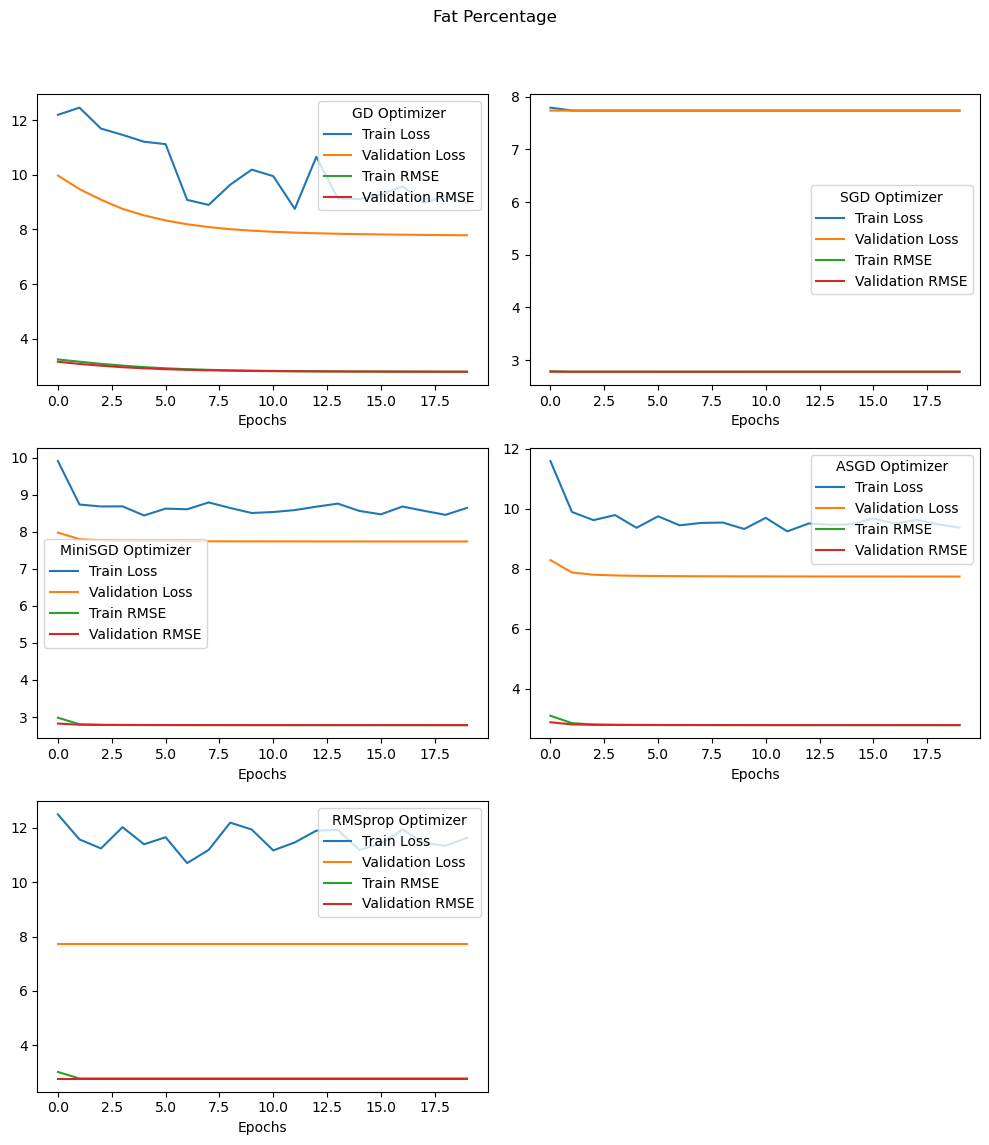

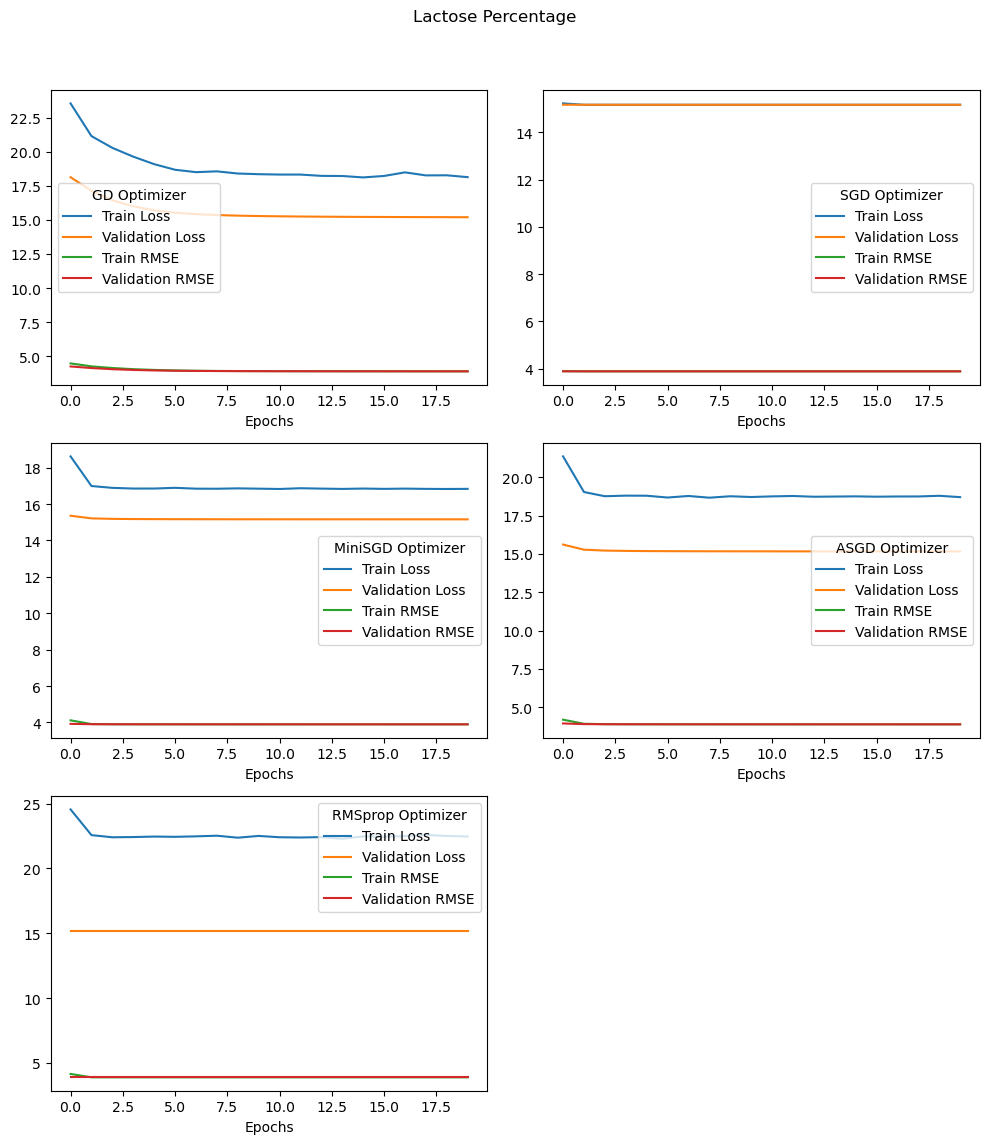

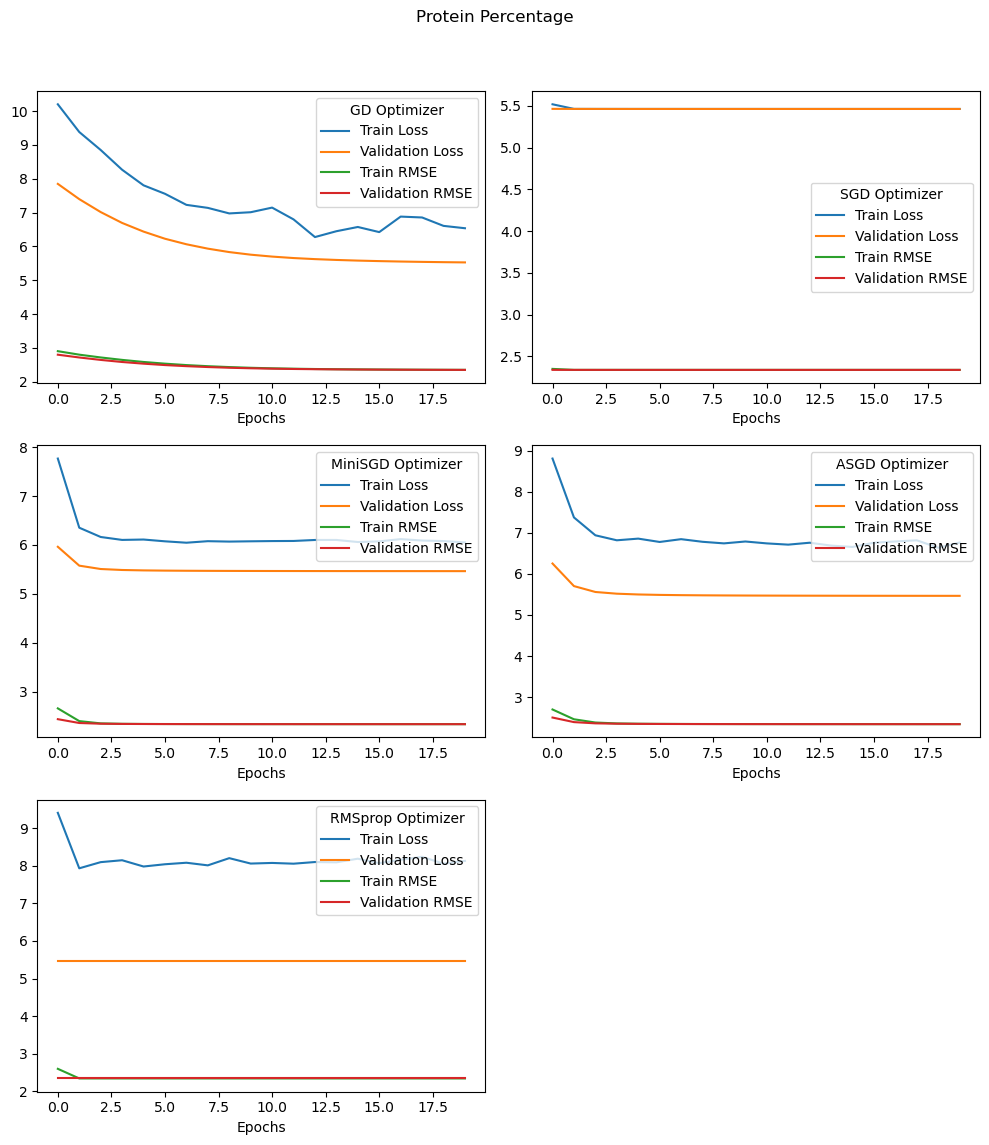

In [26]:
def plot_results(history, title):
    plt.figure(figsize=(10, 12))
    num_plots = len(history.keys())
    rows = 3
    cols = (num_plots + rows - 1) // rows
    
    for i, (nn_name, data) in enumerate(history.items(), 1):
        plt.subplot(rows, cols, i)
        plt.plot(data['metric_0'], label='Train Loss')
        plt.plot(data['metric_1'], label='Validation Loss')
        plt.plot(data['metric_2'], label='Train RMSE')
        plt.plot(data['metric_3'], label='Validation RMSE')
        plt.xlabel('Epochs')
        plt.legend(title=nn_name + ' Optimizer')
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
    plt.show()

# Plot results for each target variable
plot_results(avg_history_fat, "Fat Percentage")
plot_results(avg_history_lactose, "Lactose Percentage")
plot_results(avg_history_protein, "Protein Percentage")


# NEAT

In [37]:
device = 'cpu'
temp_config_path = "temp_config_feedforward_xor"

def fitness_function(genomes, config, inputs, expected_outputs):
    inputs_list = inputs.tolist() if isinstance(inputs, torch.Tensor) else inputs
    outputs_list = expected_outputs.tolist() if isinstance(expected_outputs, torch.Tensor) else expected_outputs
    
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = 0.0
        for xi, xo in zip(inputs_list, outputs_list):
            output = net.activate(xi)
            genome.fitness -= float((output[0] - xo) ** 2)

class StdOutReporter(neat.reporting.BaseReporter):
    def post_evaluate(self, config, population, species, best_genome):
        fit_mean = np.mean([g.fitness for g in population.values() if g.fitness is not None])
        fit_std = np.std([g.fitness for g in population.values() if g.fitness is not None])

        best_species_id = species.get_species_id(best_genome.key)
        best_fitness = float(best_genome.fitness)
        print('Population\'s average fitness: {0:3.5f} stdev: {1:3.5f}'.format(fit_mean, fit_std))
        print('Best fitness: {0:3.5f} - size: {1!r} - species {2} - id {3}'.format(best_fitness,
                                                                                     best_genome.size(),
                                                                                     best_species_id,
                                                                                     best_genome.key))

def run_neat_for_target(inputs, outputs, config, num_generations=15):
    pop = neat.Population(config)
    pop.add_reporter(neat.StdOutReporter(True))
    pop.add_reporter(StdOutReporter())
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)

    # Function to calculate fitness for each genome
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            genome.fitness = 0.0
            for xi, xo in zip(inputs, outputs):
                output = net.activate(xi)
                genome.fitness -= float((output[0] - xo) ** 2)

    # Run NEAT and collect fitness history
    fitness_history = []

    for gen in range(num_generations):
        pop.run(eval_genomes, 1)
        gen_fitnesses = [-genome.fitness for genome in pop.population.values() if genome.fitness is not None]
        gen_rmse = np.sqrt(np.mean(gen_fitnesses))
        fitness_history.append(gen_rmse)

    return fitness_history

# Load configuration file with UTF-8 encoding
config_path = "config-feedforward-xor"
temp_config_path = "temp_config_feedforward_xor"

# Read the configuration file with UTF-8 encoding, and handle errors
with open(config_path, 'r', encoding='utf-8', errors='replace') as f:
    content = f.read()

# Remove problematic characters
cleaned_content = ''.join(c for c in content if ord(c) < 128)

# Write cleaned content to a temporary file with UTF-8 encoding
with open(temp_config_path, 'w', encoding='utf-8') as f:
    f.write(cleaned_content)

# Load configuration using the temporary file
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                            neat.DefaultSpeciesSet, neat.DefaultStagnation,
                            temp_config_path)

# Train NEAT models for each target
num_generations = 20
target_rmse = {
    'lactose': [[] for _ in range(num_generations)],
    'fat': [[] for _ in range(num_generations)],
    'protein': [[] for _ in range(num_generations)]
}

for fold_idx in range(len(X_train_kf)):
    X_train_fold = X_train_kf[fold_idx]
    y_fat_train_fold = y_fat_train_kf[fold_idx]
    y_lactose_train_fold = y_lactose_train_kf[fold_idx]
    y_protein_train_fold = y_protein_train_kf[fold_idx]

    # Convert data to numpy arrays
    X_train_fold_np = X_train_fold.cpu().numpy()
    y_fat_train_fold_np = y_fat_train_fold.cpu().numpy()
    y_lactose_train_fold_np = y_lactose_train_fold.cpu().numpy()
    y_protein_train_fold_np = y_protein_train_fold.cpu().numpy()
    
    # Run NEAT for each target
    lactose_rmse = run_neat_for_target(X_train_fold_np, y_lactose_train_fold_np, config, num_generations)
    fat_rmse = run_neat_for_target(X_train_fold_np, y_fat_train_fold_np, config, num_generations)
    protein_rmse = run_neat_for_target(X_train_fold_np, y_protein_train_fold_np, config, num_generations)
    
    for gen in range(num_generations):
        target_rmse['lactose'][gen].append(lactose_rmse[gen])
        target_rmse['fat'][gen].append(fat_rmse[gen])
        target_rmse['protein'][gen].append(protein_rmse[gen])

# Calculate average RMSE for each epoch across folds
average_rmse = {
    'lactose': [np.mean(rmses) for rmses in target_rmse['lactose']],
    'fat': [np.mean(rmses) for rmses in target_rmse['fat']],
    'protein': [np.mean(rmses) for rmses in target_rmse['protein']]
}

NameError: name 'neat' is not defined

In [ ]:
# Plot the RMSE values for each target
epochs = range(1, num_generations + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, average_rmse['lactose'], label='Lactose RMSE', marker='o')
plt.plot(epochs, average_rmse['fat'], label='Fat RMSE', marker='o')
plt.plot(epochs, average_rmse['protein'], label='Protein RMSE', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Lactose, Fat, and Protein across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# GSGP

In [38]:
seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1

# Setup logging properties
file_dir = './log/'
file_name = 'intro_gsgp.log'
log_path = file_dir + file_name
path_rts = os.path.join(file_dir, 'reconstruct', 'rts')
path_init_pop = os.path.join(file_dir, 'reconstruct', 'init_pop')

if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

for path_i in [file_dir, path_init_pop, path_rts]:
    if not os.path.exists(path_i):
        os.makedirs(path_i)

print([log_path, path_rts, path_init_pop])

['./log/intro_gsgp.log', './log/reconstruct\\rts', './log/reconstruct\\init_pop']


In [39]:
for i in range(0, len(X_train_kf)):
    batch_size = len(X_train_kf[i])
    ds_train_kf = TensorDataset(X_train_kf[i], y_lactose_train_kf[i])
    ds_val_kf = TensorDataset(X_val_kf[i], y_lactose_val_kf[i])
    dl_train_1  =DataLoader(ds_train_kf, batch_size, shuffle)
    dl_val_1 = DataLoader(ds_val_kf, batch_size, shuffle)
    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]
    sspace_sml_gs = {
        'n_dims': X_train_kf[i].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device,
        'n_batches': 1
    }
    pi_sml = SML(
    sspace=sspace_sml_gs,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train_1, dl_test=dl_val_1
)
    ps = batch_size
    selection_pressure = .07
    mutation_prob = .1
    xo_prob = .9
    seed = 1
    has_elitism = True
    allow_reproduction = False
    to, by = 5.0, 0.25
    ms = torch.arange(by, to + by, by, device=device)

    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=grow,
        selector=prm_tournament(pressure=selection_pressure),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        #
        # Notice that, in GPOL-based implementation that we are using, 
        # these operators are the only settings that 
        # are necessary to define a Geometric Semantic GP.
        #
        crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
        mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
)
       
    mheuristic._initialize()
    print(mheuristic.pop)
    print('------------------------')
    print(mheuristic.best_sol.fit)
    print(mheuristic.best_sol.printTree())
    print('------------------------')

0)	[sub, mul, div, 12, tensor(-0.9433), 0, 7] (fit: tensor(5.3093))
1)	[add, add, 0, 13, sub, 17, 7] (fit: tensor(4.5737))
2)	[div, div, 9, 16, 6] (fit: tensor(12.3677))
3)	[mul, 16, 1] (fit: tensor(4.8076))
4)	[div, 5, 11] (fit: tensor(4.1035))
5)	[add, sub, 0, tensor(0.4068), 5] (fit: tensor(4.5907))
6)	[sub, 17, 11] (fit: tensor(5.3644))
7)	[mul, 19, div, 17, 1] (fit: tensor(4.8767))
8)	[div, div, 13, tensor(0.0802), 0] (fit: tensor(106.9986))
9)	[sub, sub, mul, 2, 14, mul, 19, 2, sub, 5, 9] (fit: tensor(5.1928))
10)	[div, 3, mul, 6, 16] (fit: tensor(3.8099))
11)	[sub, 0, add, 5, 13] (fit: tensor(5.4665))
12)	[sub, 0, 10] (fit: tensor(5.0162))
13)	[div, 6, 2] (fit: tensor(5.3021))
14)	[mul, div, 17, 6, 19] (fit: tensor(4.8937))
15)	[add, mul, 13, 12, 0] (fit: tensor(4.5687))
16)	[mul, 0, sub, 18, mul, 3, 11] (fit: tensor(6.0780))
17)	[div, add, add, 17, 10, 10, mul, div, 3, tensor(-0.8536), sub, 18, tensor(0.1005)] (fit: tensor(33.6163))
18)	[add, 18, div, 1, tensor(0.3408)] (fit: t

0)	[sub, mul, div, 12, tensor(-0.9433), 0, 7] (fit: tensor(5.3382))
1)	[add, add, 0, 13, sub, 17, 7] (fit: tensor(4.5752))
2)	[div, div, 9, 16, 6] (fit: tensor(5.6984))
3)	[mul, 16, 1] (fit: tensor(4.8398))
4)	[div, 5, 11] (fit: tensor(4.2166))
5)	[add, sub, 0, tensor(0.4068), 5] (fit: tensor(4.6069))
6)	[sub, 17, 11] (fit: tensor(5.3351))
7)	[mul, 19, div, 17, 1] (fit: tensor(4.8259))
8)	[div, div, 13, tensor(0.0802), 0] (fit: tensor(103.5430))
9)	[sub, sub, mul, 2, 14, mul, 19, 2, sub, 5, 9] (fit: tensor(5.2131))
10)	[div, 3, mul, 6, 16] (fit: tensor(3.9077))
11)	[sub, 0, add, 5, 13] (fit: tensor(5.5655))
12)	[sub, 0, 10] (fit: tensor(4.9984))
13)	[div, 6, 2] (fit: tensor(7.9595))
14)	[mul, div, 17, 6, 19] (fit: tensor(4.9140))
15)	[add, mul, 13, 12, 0] (fit: tensor(4.6343))
16)	[mul, 0, sub, 18, mul, 3, 11] (fit: tensor(6.3100))
17)	[div, add, add, 17, 10, 10, mul, div, 3, tensor(-0.8536), sub, 18, tensor(0.1005)] (fit: tensor(45.6998))
18)	[add, 18, div, 1, tensor(0.3408)] (fit: te

## GSGP EFFICIENT

In [170]:
for i in range(0, len(X_train_kf)):
    batch_size = len(X_train_kf[i])

    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['exp'],
                function_map['log']]
    train_indices = []
    val_indices = []
    for j in range(0, len(X_train_kf[i])):
        train_indices.append(j)
        val_indices.append(j)
    train_index = torch.tensor(train_indices)
    val_index = torch.tensor(val_indices)

    sspace_sml_gs = {
        'n_dims': X_train_kf[i].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device
    }
    print(i)
    pi_sml_gs = SMLGS(
        sspace=sspace_sml_gs,
        ffunction=Ffunctions('rmse'),
        X=X_train_kf[i], y=y_lactose_train_kf[i],
        train_indices=train_index,
        test_indices=val_index
    )

    ps = batch_size
    # ps = 250
    selection_pressure = .07
    mutation_prob = .7
    xo_prob = .3
    has_elitism = True
    allow_reproduction = False

    mheuristic = GSGP(
        pi=pi_sml_gs,
        #
        # If individuals should be reconstructed, it must be defined before fitting the algorithm.
        #
        path_init_pop=path_init_pop, 
        path_rts=path_rts, 
        #
        # Initializer - it can be the same tree initializer as traditional GP.
        #
        initializer=grow,
        #
        # Selector - it can be the same GP selector as tradicional GP.
        #
        selector=prm_tournament(pressure=selection_pressure),
        #
        # Other Algorithm hyperparameters
        #
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        #
        # Efficient Crossover
        #
        crossover=prm_efficient_gs_xo(X_train_kf[0], prm_grow(sspace=pi_sml_gs.sspace)),
        #
        # Efficient Mutation
        #
        mutator=prm_efficient_gs_mtn(X_val_kf[0], prm_grow(sspace=pi_sml_gs.sspace), ms)
    )
    mheuristic._initialize()
    print("---------------------")
    print(mheuristic.best_sol.fit)
    print(mheuristic.best_sol.repr_)
    print(mheuristic.pi.y.shape)
    print(mheuristic.best_sol.repr_.shape)
    print("---------------------")

0
---------------------
tensor(2.2056)
tensor([2.7183, 2.7183, 1.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 1.0000,
        2.7183, 2.7183, 2.7183, 2.7183, 1.0000, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
 

---------------------
tensor(2.1744)
tensor([2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
        2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183,
   

# Wilcoxon Signed-Rank Test

In [41]:
# Function to average RMSE values across optimizers
def average_rmse_across_optimizers(history):
    avg_rmse_train = []
    avg_rmse_valid = []
    for nn_name, folds_history in history.items():
        rmse_train_folds = []
        rmse_valid_folds = []
        for fold_name, metrics in folds_history.items():
            _, _, rmse_train, rmse_valid = metrics
            rmse_train_folds.append(rmse_train)
            rmse_valid_folds.append(rmse_valid)
        avg_rmse_train.append(np.mean(rmse_train_folds, axis=0))
        avg_rmse_valid.append(np.mean(rmse_valid_folds, axis=0))
    return np.mean(avg_rmse_train, axis=0), np.mean(avg_rmse_valid, axis=0)

# Average RMSE values across optimizers for each target
avg_rmse_train_fat, avg_rmse_valid_fat = average_rmse_across_optimizers(history_kfold_fat)
avg_rmse_train_lactose, avg_rmse_valid_lactose = average_rmse_across_optimizers(history_kfold_lactose)
avg_rmse_train_protein, avg_rmse_valid_protein = average_rmse_across_optimizers(history_kfold_protein)

# Use NEAT RMSE values (assuming they are precomputed)
neat_rmse_fat = average_rmse['fat']
neat_rmse_lactose = average_rmse['lactose']
neat_rmse_protein = average_rmse['protein']

# Perform Wilcoxon Signed-Rank Test
def perform_wilcoxon_test(avg_rmse_nn, neat_rmse, target_variable):
    # Ensure both lists have the same length for a valid test
    min_length = min(len(avg_rmse_nn), len(neat_rmse))
    avg_rmse_nn = avg_rmse_nn[:min_length]
    neat_rmse = neat_rmse[:min_length]
    
    stat, p_value = wilcoxon(avg_rmse_nn, neat_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

# Perform tests for each target variable
perform_wilcoxon_test(avg_rmse_valid_fat, neat_rmse_fat, "fat")
perform_wilcoxon_test(avg_rmse_valid_lactose, neat_rmse_lactose, "lactose")
perform_wilcoxon_test(avg_rmse_valid_protein, neat_rmse_protein, "protein")

NameError: name 'average_rmse' is not defined

In [165]:
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.datasets import load_boston
seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# Defines parameters for the data usage
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1
# Boston dataset
X, y = load_boston(X_y=True)
print(X.shape, y.shape)
print(X[:3])
print(y[:3])
# Data split

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=p_test, seed=seed)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, p_test=p_val, seed=seed)
total_batches = 1
batch_size = X_train.shape[0]


# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_val, y_val)
print("----------")
# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)

ds_train_kf = TensorDataset(X_train_kf[0], y_lactose_train_kf[0])
ds_val_kf = TensorDataset(X_val_kf[0], y_lactose_val_kf[0])
dl_train_1  =DataLoader(ds_train_kf, batch_size, shuffle)
dl_val_1 = DataLoader(ds_val_kf, batch_size, shuffle)
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

print(X_train.size(),y_train.size())
print(X_train_kf[0].size(),y_lactose_train_kf[0].size())

print(y_lactose_train_kf[0])
#print(y_train)


sspace_sml = {
    'n_dims': 20,
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 10, 
    'n_batches': total_batches,
    'device': device
}
pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train_1, dl_test=dl_val_1,  # For the algorithm, the unseen is our validation!
    n_jobs=8
)

ps = 249
selection_pressure = .07
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)
mheuristic._initialize()

torch.Size([506, 13]) torch.Size([506])
tensor([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01, 6.5750e+00,
         6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02, 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01, 6.4210e+00,
         7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02, 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01, 7.1850e+00,
         6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02, 1.7800e+01, 3.9283e+02,
         4.0300e+00]])
tensor([24.0000, 21.6000, 34.7000])
----------
torch.Size([249, 13]) torch.Size([249])
torch.Size([259, 20]) torch.Size([259])
tensor([4.9535, 4.9831, 4.8891, 4.8454, 4.9137, 4.8445, 4.8322, 4.8589, 4.8249,
        4.9186, 4.9068, 4.8665, 4.9534, 4.8893, 4.9084, 4.8970, 4.8349, 4.8273,
        5.0106, 4.9701, 4.9917, 4.9765, 4.8565, 4.9054, 4.8432, 4.8228, 4.8116,
        4.8298, 4.8017, 4.8639, 4.8999, 

In [47]:
print(mheuristic.pop.individuals[0].repr_)

[sub, mul, div, 6, tensor(-0.9433), 12, div, 3, mul, tensor(0.2991), 6]


In [48]:
print(f'\nGP population: {mheuristic.pop.__class__} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}')

print(f'\nGP best individual {mheuristic.best_sol.printTree(out="string")}, fitness {mheuristic.best_sol.fit}\n\n')



GP population: <class 'gpolnel.utils.population.PopulationTree'> (250 individuals)

Poppulation fitness tensor([1250.3567,   40.7757, 6774.2671])...
Poppulation valid [True, True, True]...

Individual 0: [sub, mul, div, 6, tensor(-0.9433), 12, div, 3, mul, tensor(0.2991), 6], fitness 1250.356689453125
Individual 1: [sub, sub, 8, 10, div, 6, 11], fitness 40.77573013305664
Individual 2: [mul, 11, 10], fitness 6774.26708984375

GP best individual add( x_10, x_4 ), fitness 11.814071655273438




In [49]:
# Log settings
file_dir = './log/'
file_name = 'intro.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)

if not os.path.exists(file_dir):
    os.makedirs(file_dir)

# Learning
n_iter = 50
mheuristic.solve(
    n_iter,
    verbose=3, log=3, log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
------------------------
10.021615982055664
111111
8.905240058898926
222222
0.14199423789978027
33333
-1.0 -1.0
------------------------
------------------------
8.572311401367188
111111
8.449854850769043
222222
0.1493074893951416
33333
-1.0 -1.0
------------------------
------------------------
8.572311401367188
111111
8.449854850769043
222222
0.15743303298950195
33333
-1.0 -1.0
------------------------
------------------------
8.275691032409668
111111
7.870112895965576
22222

## GA

In [166]:
seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    
# Defines parameters for the data usage
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1

fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]
print(dir(dl_val))
sspace_sml = {
    'n_dims': X.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 10, 
    'n_batches': total_batches,
    'device': device
}
pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train_1, dl_test= dl_val_1,  # For the algorithm, the unseen is our validation!
    n_jobs=8
)
print(dir(dl_val_1))

ps = 249
selection_pressure = .07
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)

mheuristic._initialize()
print(mheuristic.pop)
print(mheuristic.pop.individuals[0].repr_)


['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']
['_DataLoader__initialized', '_DataLoader__multiproce

In [167]:
mheuristic.pop.individuals[0].printTree()
boston_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']
mheuristic.pop.individuals[0].printTree(feature_names=boston_features)

sub( mul( div( x_6, -0.9433 ) x_12 ) div( x_3, mul( 0.2991, x_6 ) ) )
sub( mul( div( age, -0.9433 ) medv ) div( chas, mul( 0.2991, age ) ) )


In [168]:
#print(f'\nGP population: {mheuristic.pop._class_} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}')

print(f'\nGP best individual {mheuristic.best_sol.printTree(out="string")}, fitness {mheuristic.best_sol.fit}\n\n')

# Log settings
file_dir = './log/'
file_name = 'intro5.log'
log_path = file_dir + file_name
print("----------------")
print(file_dir)
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

n_iter = 50


Poppulation fitness tensor([34.8344,  6.4864,  5.1519])...
Poppulation valid [True, True, True]...

Individual 0: [sub, mul, div, 6, tensor(-0.9433), 12, div, 3, mul, tensor(0.2991), 6], fitness 34.834415435791016
Individual 1: [sub, sub, 8, 10, div, 6, 11], fitness 6.486408233642578
Individual 2: [mul, 11, 10], fitness 5.151920318603516

GP best individual div( -0.3908, x_9 ), fitness 3.392198085784912


----------------
./log/


In [169]:
n_iter = 50
mheuristic.solve(
    n_iter,
    verbose=3, log=3, log_path=log_path,
    test_elite=True
)

print("aaa")
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Val fitness history
history_val_fits = [float(row[9].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [int(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]

mheuristic.best_sol.printTree()

unique = [el for el in mheuristic.best_sol.repr_ if isinstance(el, int)]
counts = {}

for value in unique:
    if value in counts:
        counts[value] += 1
    else:
        counts[value] = 1

for value, count in counts.items():
    print(f'Feature {value}: {count}')
print('')

for value, count in counts.items():
    print(f'Feature {boston_features[value]}: {count}')

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
------------------------
3.8970444202423096
111111
3.8825669288635254
222222
0.15008234977722168
33333
-1.0 -1.0
------------------------
------------------------
3.328423500061035
111111
3.3065848350524902
222222
0.14873313903808594
33333
-1.0 -1.0
------------------------
------------------------
2.386899709701538
111111
2.5108394622802734
222222
0.14347124099731445
33333
-1.0 -1.0
------------------------
------------------------
1.014232873916626
111111
1.1552317142486572


FileNotFoundError: [Errno 2] No such file or directory: './log/intro5.log'

In [35]:
os.close()

TypeError: close() missing required argument 'fd' (pos 1)